## Lettura dati


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

# Funzione per ordinare i file in base alla temperatura e alla dimensione del lattice
def sort_files(file_pattern):
    files = glob.glob(file_pattern)
    
    def sort_key(filename):
        match = re.search(r'T(\d+(\.\d+)?)_N(\d+)', filename)
        if match:
            temp = float(match.group(1))
            size = int(match.group(3))
            return (temp, size)
        return (0, 0)  # Valore di default nel caso in cui il pattern non corrisponda
    
    files.sort(key=sort_key)
    return files




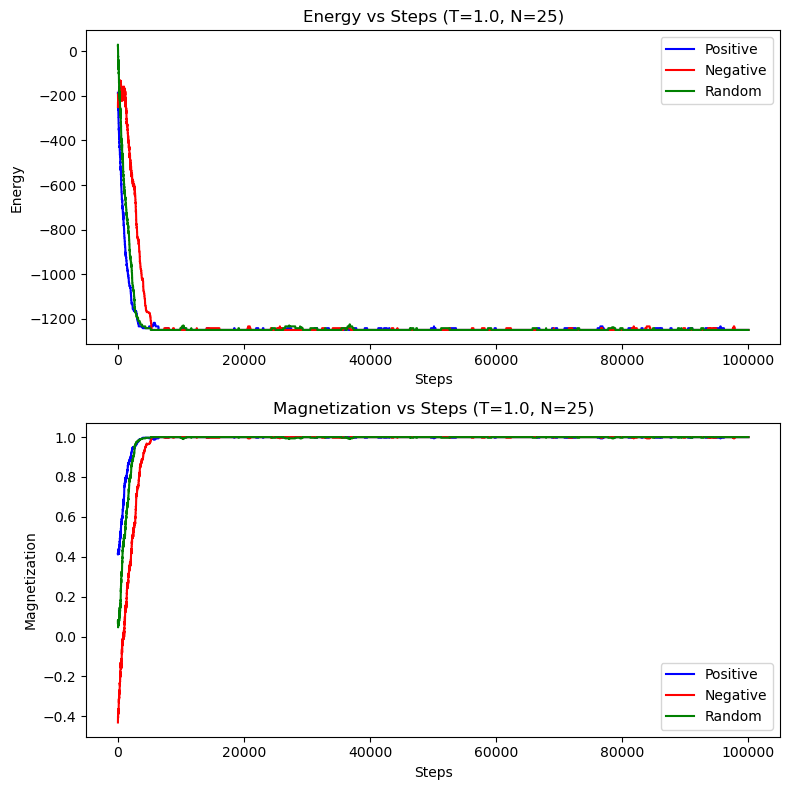

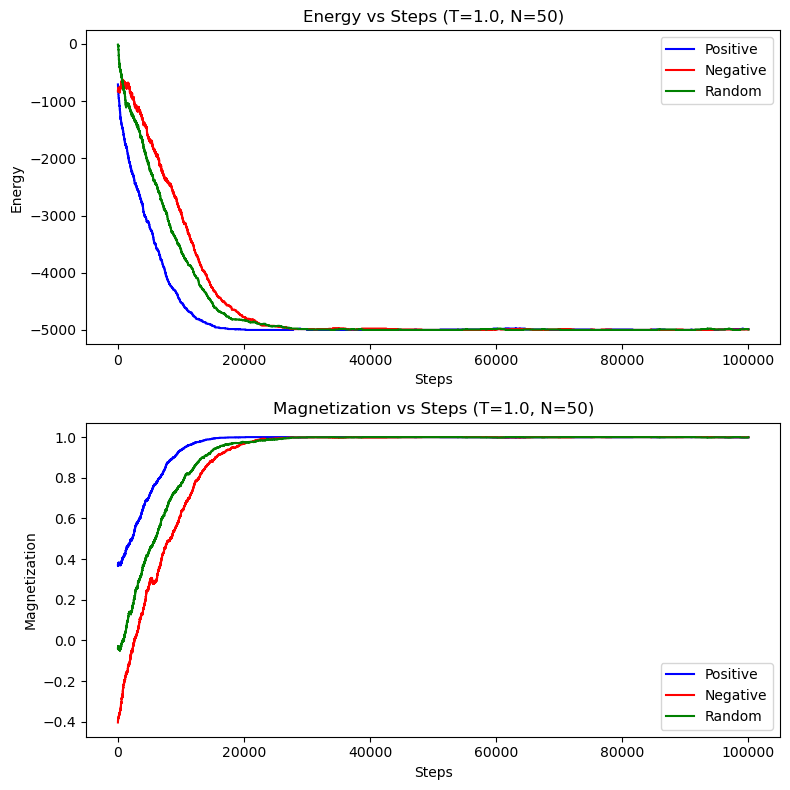

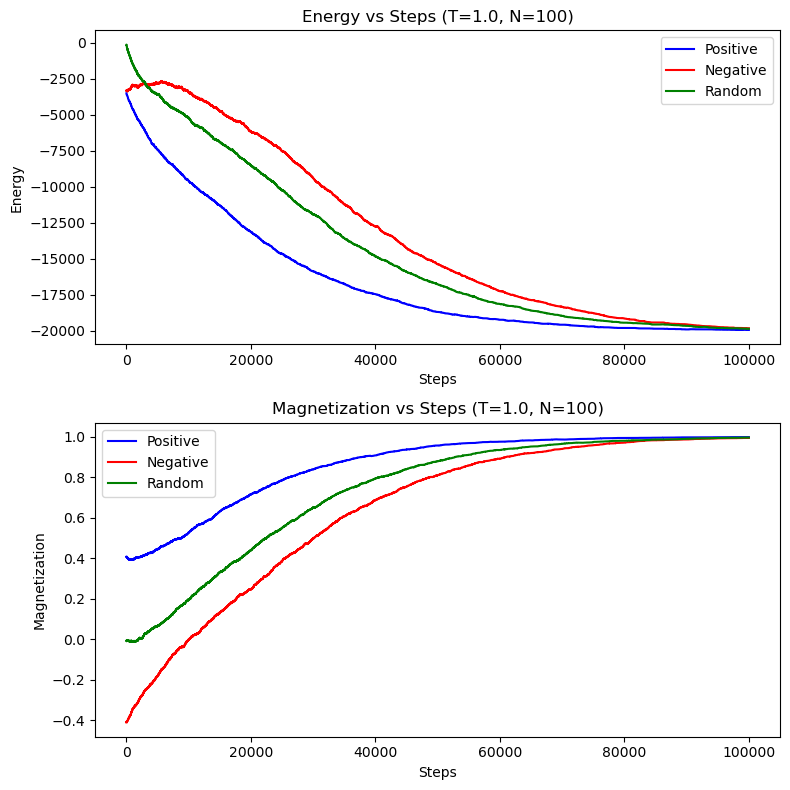

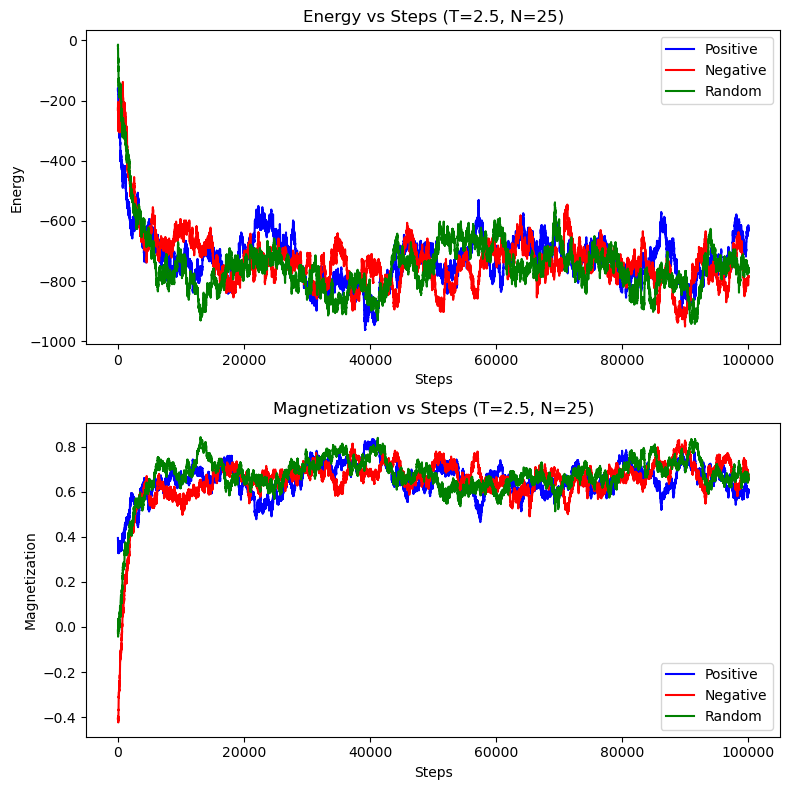

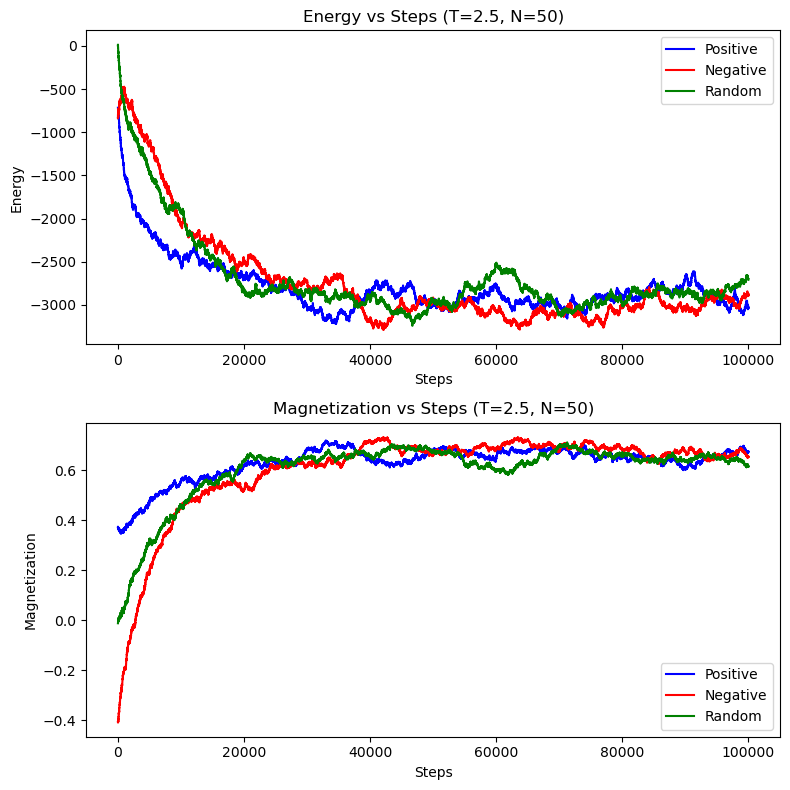

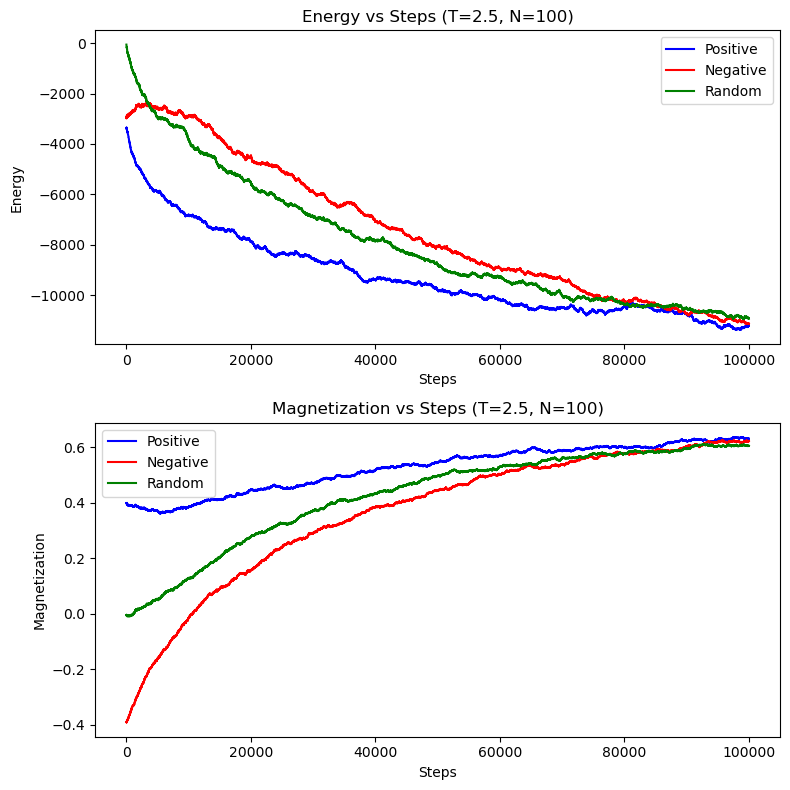

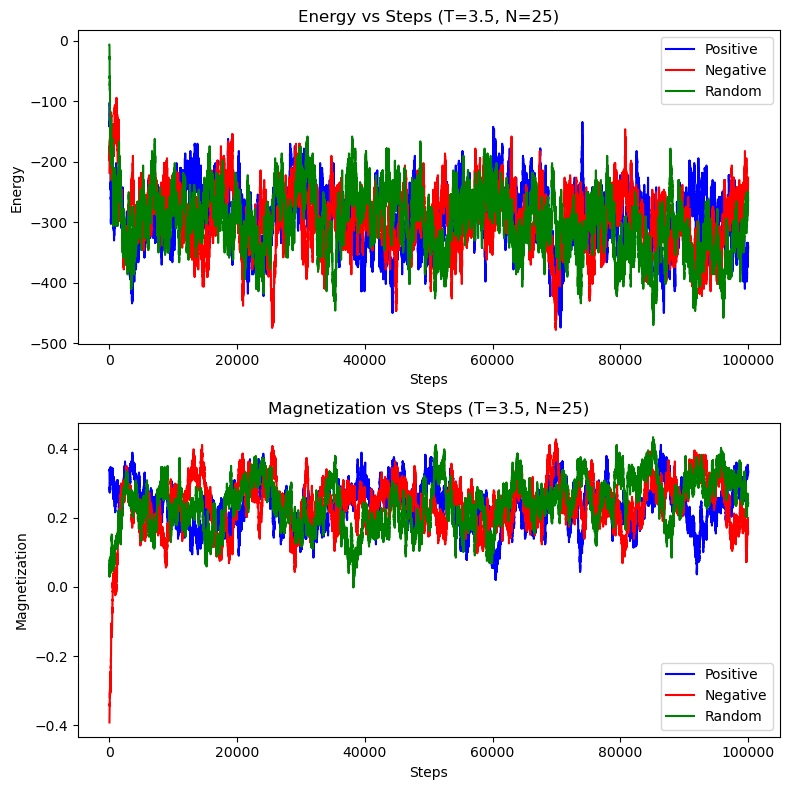

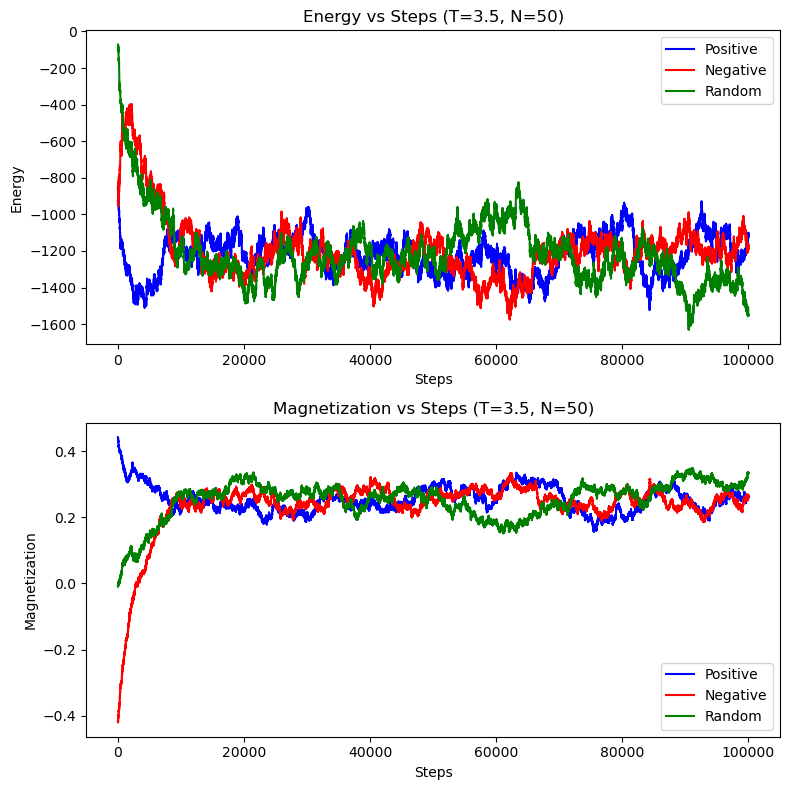

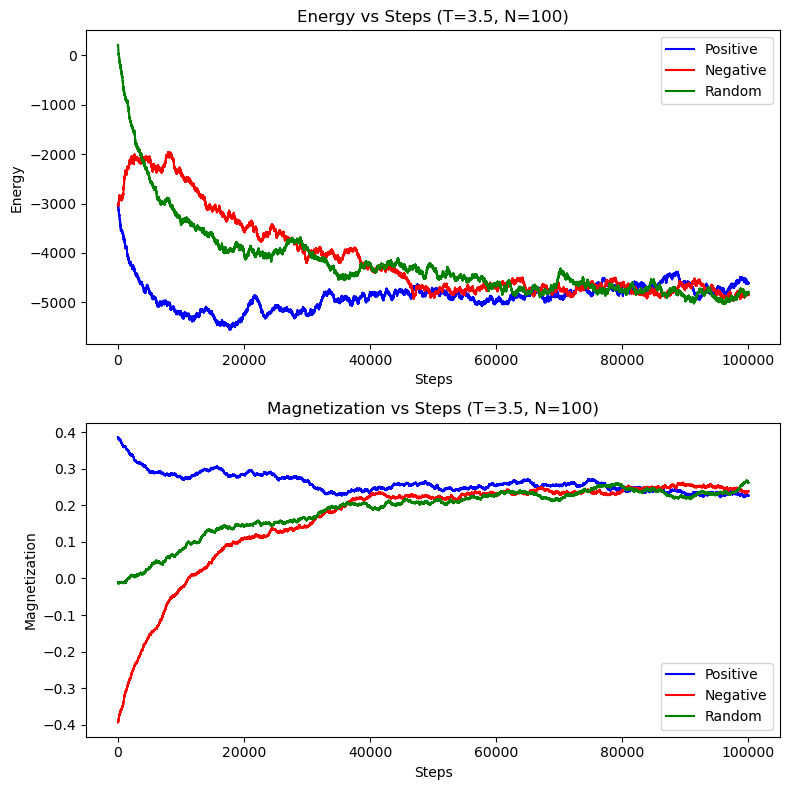

In [46]:


# Funzione per leggere i dati dai file
def read_data_1(files):
    data = {}
    
    for file in files:
        # Estrazione di temperatura, dimensione e configurazione dal nome del file
        match = re.search(r'T(\d+(\.\d+)?)_N(\d+)_([a-zA-Z]+)', file)
        if match:
            temp = float(match.group(1))
            size = int(match.group(3))
            config = match.group(4)  # Configurazione (positive, negative, random)
            key = f'T{temp}_N{size}'
            
            if key not in data:
                data[key] = {}
            
            if config not in data[key]:
                data[key][config] = {'steps': [], 'energies': [], 'magnetizations': []}
            
            with open(file, 'r') as f:
                for line in f:
                    parts = line.split()
                    method, step, energy, magnetization = parts[0], int(parts[1]), float(parts[2]), float(parts[3])
                    data[key][config]['steps'].append(step)
                    data[key][config]['energies'].append(energy)
                    data[key][config]['magnetizations'].append(magnetization)
    
    return data

# Funzione per visualizzare i dati
def plot_data_1(data):
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    for key in data:
        temp, size = key.split('_')
        temp = temp[1:]
        size = size[1:]
        
        plt.figure(figsize=(8, 8))
        
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[key]:
                plt.plot(data[key][config]['steps'], data[key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[key]:
                plt.plot(data[key][config]['steps'], data[key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        
        #plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization')
        #plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step ')
        
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Main script

sorted_files=sort_files('dati_file_txt/ising_data_T*.txt')
data = read_data_1(sorted_files)

plot_data_1(data)


## ANALISI DATI T=1.0 N=25

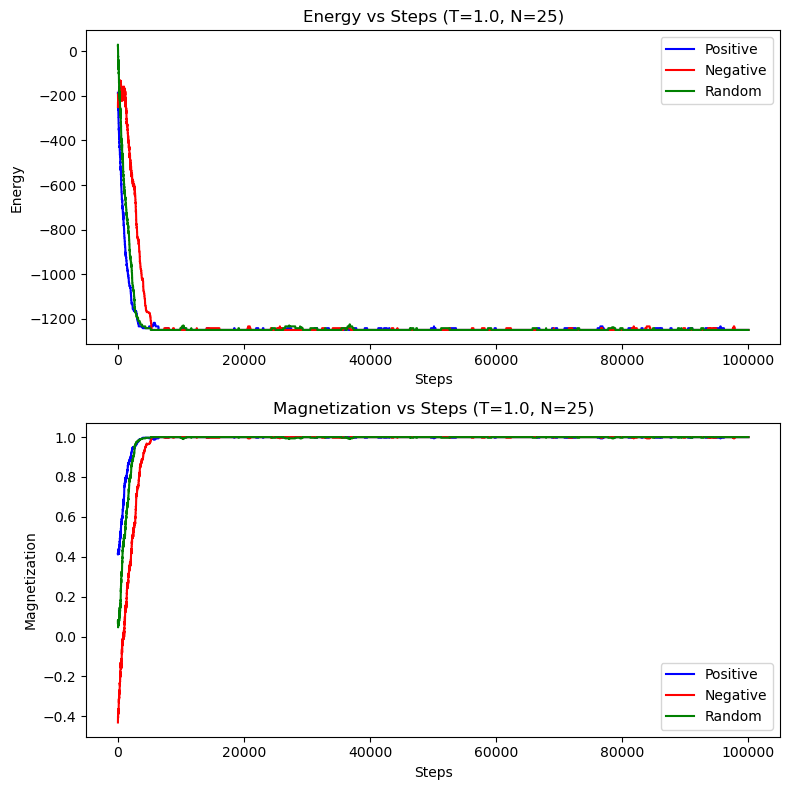

In [55]:
def plot_data_for_selected_key(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(8, 8))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

# Esempio di utilizzo
selected_key = 'T1.0_N25'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key(data, selected_key)

In [86]:
import numpy as np

def calculate_ensemble_averages_for_selected_key(data, selected_key, equilibrium_step, T, N):
    results = {}
    
    if selected_key in data:
        results[selected_key] = {}
        for config in data[selected_key]:
            steps = np.array(data[selected_key][config]['steps'])
            magnetizations = np.array(data[selected_key][config]['magnetizations'])
            energies = np.array(data[selected_key][config]['energies'])

            # Seleziona solo i dati dopo il tempo di equilibrio
            indices = steps >= equilibrium_step
            equilibrium_magnetizations = magnetizations[indices]
            equilibrium_energies = energies[indices]

            # Calcola la media e la varianza della magnetizzazione e dell'energia
            avg_magnetization = np.mean(equilibrium_magnetizations)
            avg_energy = np.mean(equilibrium_energies)
            avg_magnetization_squared = np.mean(equilibrium_magnetizations**2)
            avg_energy_squared = np.mean(equilibrium_energies**2)

            # Calcola il calore specifico e la suscettività magnetica
            specific_heat = (avg_energy_squared - avg_energy**2) / (T**2)
            susceptibility = (avg_magnetization_squared - avg_magnetization**2) / (T )

            results[selected_key][config] = {
                'average_magnetization': avg_magnetization,
                'average_energy': avg_energy,
                'specific_heat': specific_heat,
                'susceptibility': susceptibility
            }
    
    return results




In [87]:
# Funzione per visualizzare i risultati
def plot_results(results, selected_key):
    if selected_key in results:
        configs = list(results[selected_key].keys())

        # Prepara i dati per il grafico
        magnetizations = [results[selected_key][config]['average_magnetization'] for config in configs]
        energies = [results[selected_key][config]['average_energy'] for config in configs]
        specific_heats = [results[selected_key][config]['specific_heat'] for config in configs]
        susceptibilities = [results[selected_key][config]['susceptibility'] for config in configs]

        # Crea grafici per magnetizzazione, energia, calore specifico e suscettività magnetica
        plt.figure(figsize=(12, 10))

        plt.subplot(2, 2, 1)
        plt.bar(configs, magnetizations, color='b')
        plt.title(f'Average Magnetization per Spin (T={selected_key.split("_")[0][1:]}, N={selected_key.split("_")[1][1:]})')
        plt.ylabel('Magnetization')

        plt.subplot(2, 2, 2)
        plt.bar(configs, energies, color='r')
        plt.title(f'Average Energy per Spin (T={selected_key.split("_")[0][1:]}, N={selected_key.split("_")[1][1:]})')
        plt.ylabel('Energy')

        plt.subplot(2, 2, 3)
        plt.bar(configs, specific_heats, color='g')
        plt.title(f'Specific Heat (T={selected_key.split("_")[0][1:]}, N={selected_key.split("_")[1][1:]})')
        plt.ylabel('Specific Heat')

        plt.subplot(2, 2, 4)
        plt.bar(configs, susceptibilities, color='m')
        plt.title(f'Magnetic Susceptibility (T={selected_key.split("_")[0][1:]}, N={selected_key.split("_")[1][1:]})')
        plt.ylabel('Susceptibility')

        plt.tight_layout()
        plt.show()

    else:
        print(f'Data for {selected_key} not found.')



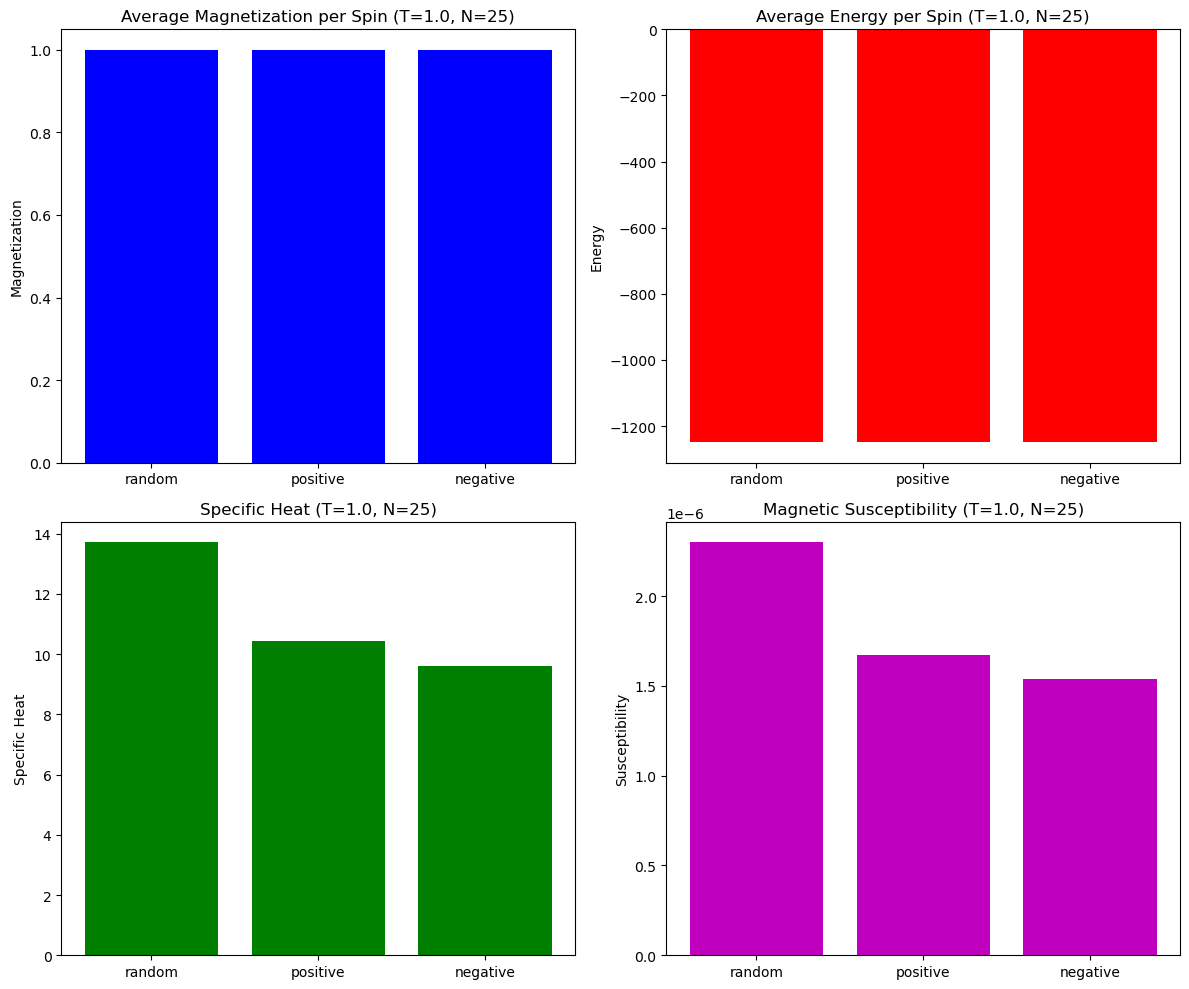

In [88]:
# Parametri
equilibrium_step = 6211  # Questo valore dovrebbe essere determinato precedentemente
T = 1.0  # Temperatura
N = 25   # Dimensione del lattice
selected_key = 'T1.0_N25'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_1025 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_1025, selected_key)

## ANALISI DATI T=1 N=50

In [59]:
def plot_data_for_selected_key_1050(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(20000,30000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

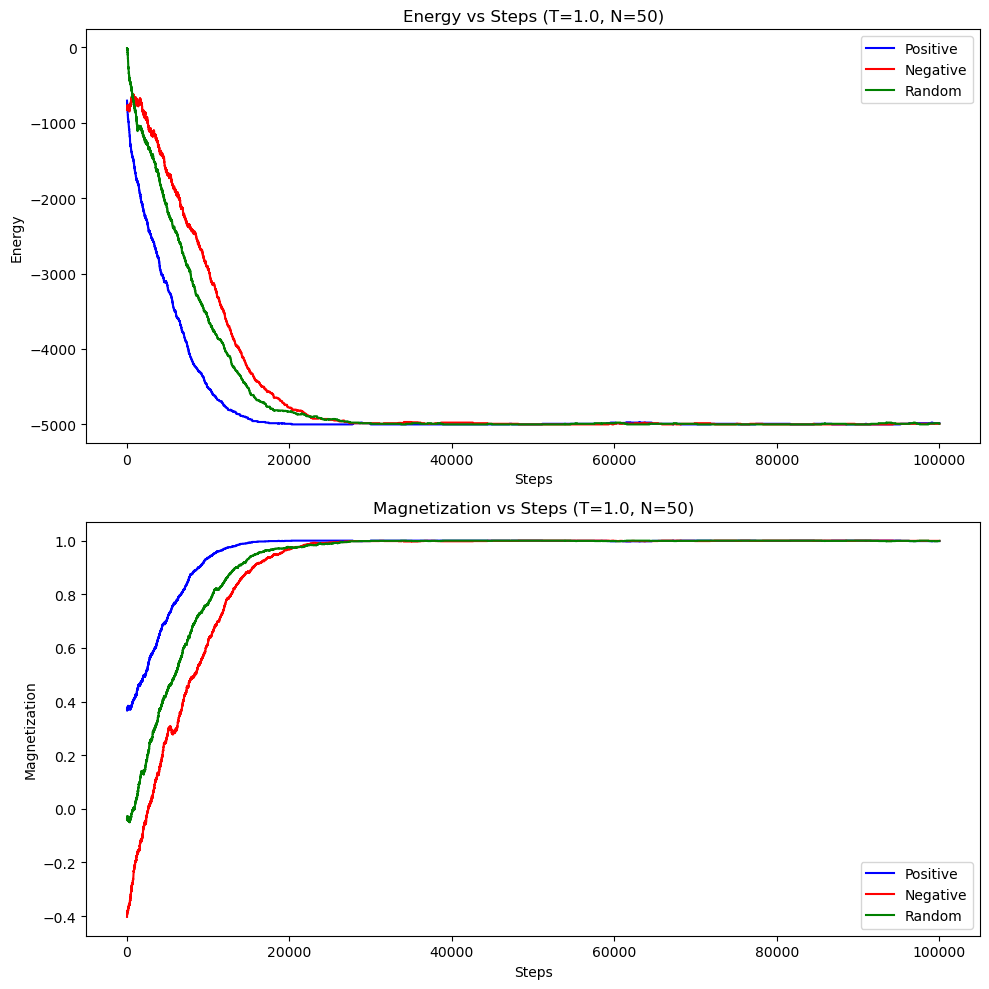

In [60]:
selected_key = 'T1.0_N50'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_1050(data, selected_key)

prendiamo 26000 circa

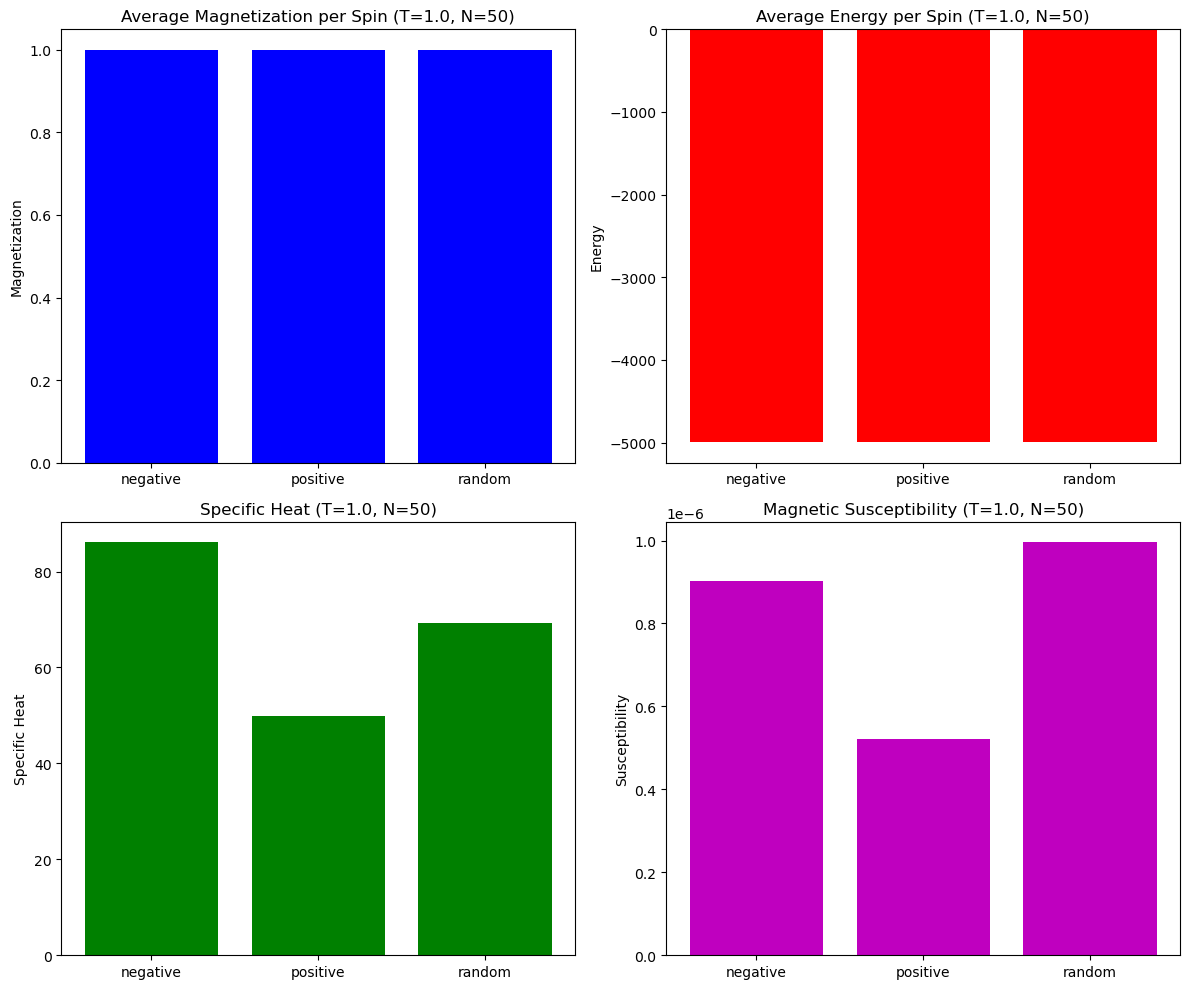

In [61]:
# Parametri
equilibrium_step = 26000  # Questo valore dovrebbe essere determinato precedentemente
T = 1.0  # Temperatura
N = 50   # Dimensione del lattice
selected_key = 'T1.0_N50'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_1050 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_1050, selected_key)

## ANALISI DATI PER T=1 N=100


In [62]:
def plot_data_for_selected_key_1010(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(80000,100000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

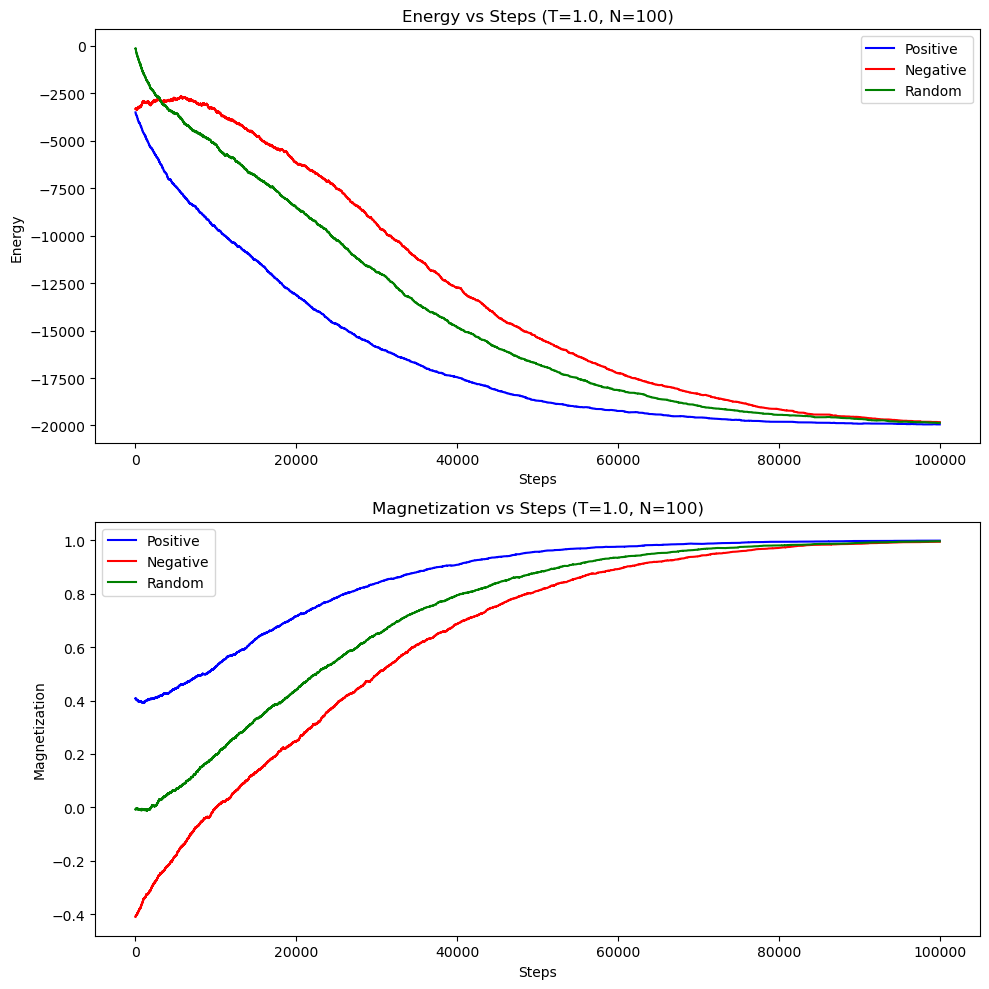

In [63]:
selected_key = 'T1.0_N100'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_1010(data, selected_key)

PRENDIAMO 80000

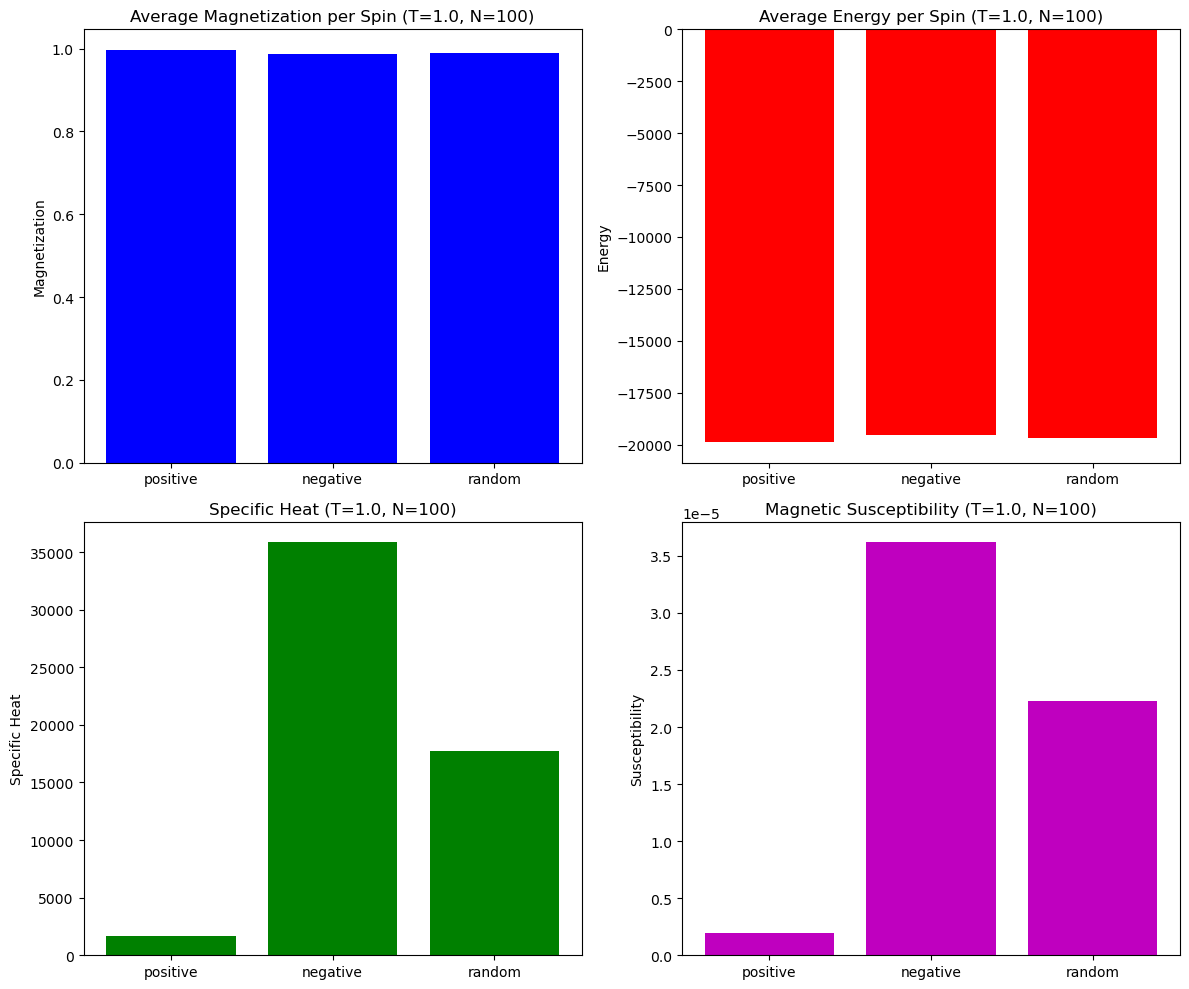

In [64]:
# Parametri
equilibrium_step = 80000  # Questo valore dovrebbe essere determinato precedentemente
T = 1.0  # Temperatura
N = 100   # Dimensione del lattice
selected_key = 'T1.0_N100'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_1010 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_1010, selected_key)

## ANALISI DATI T=2,5 N=25

In [65]:
def plot_data_for_selected_key_2525(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(5000,7500)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

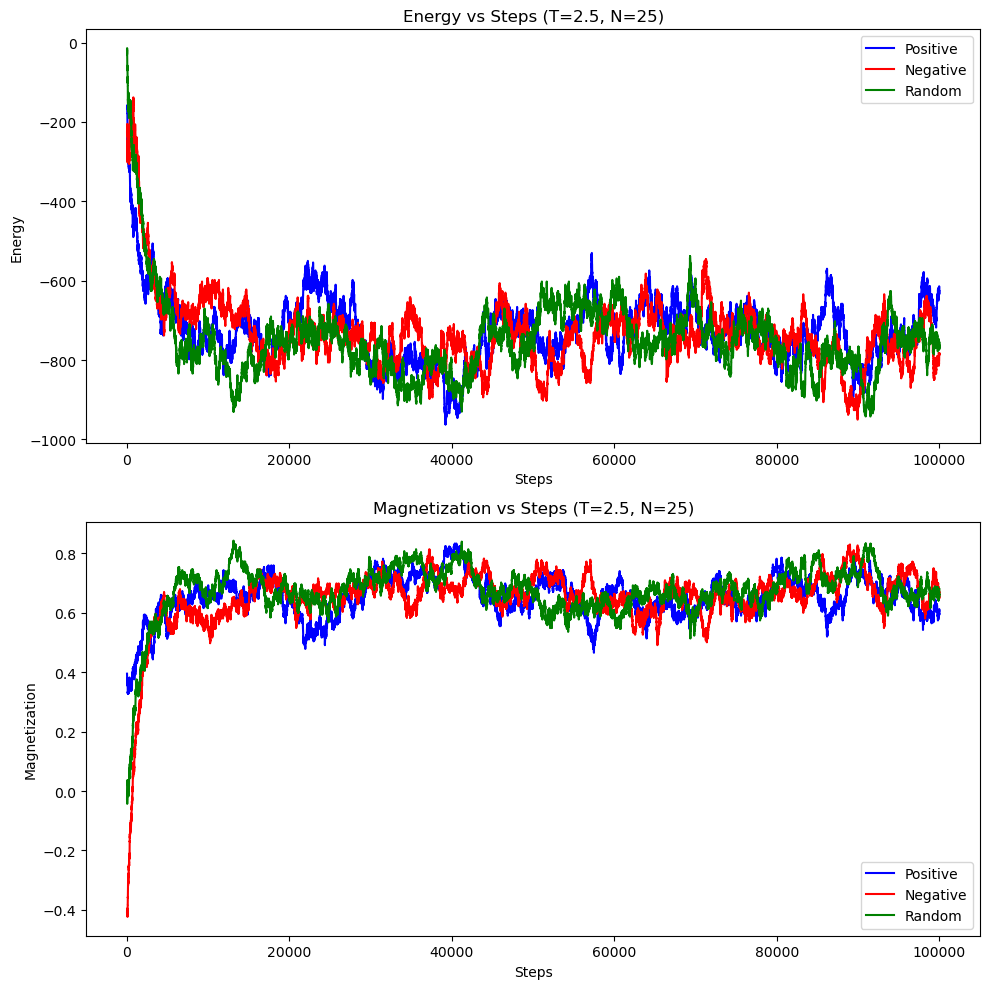

In [66]:
selected_key = 'T2.5_N25'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_2525(data, selected_key)

PRENDIAMO 5000

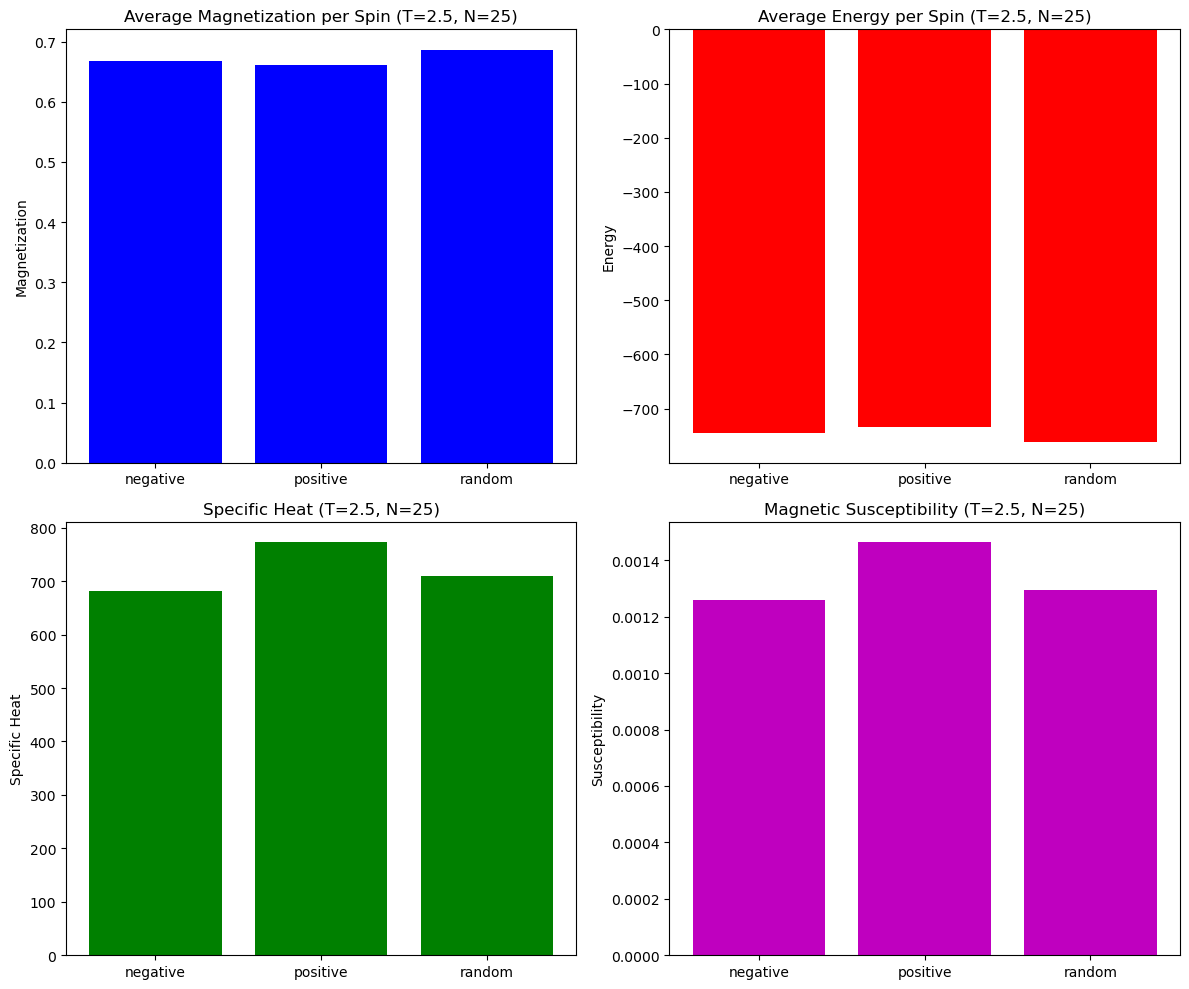

In [67]:
# Parametri
equilibrium_step = 5000  # Questo valore dovrebbe essere determinato precedentemente
T = 2.5  # Temperatura
N = 25  # Dimensione del lattice
selected_key = 'T2.5_N25'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_2525 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_2525, selected_key)

## ANALISI DATI T=2,5 N=50


In [68]:
def plot_data_for_selected_key_2550(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(25000,27500)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

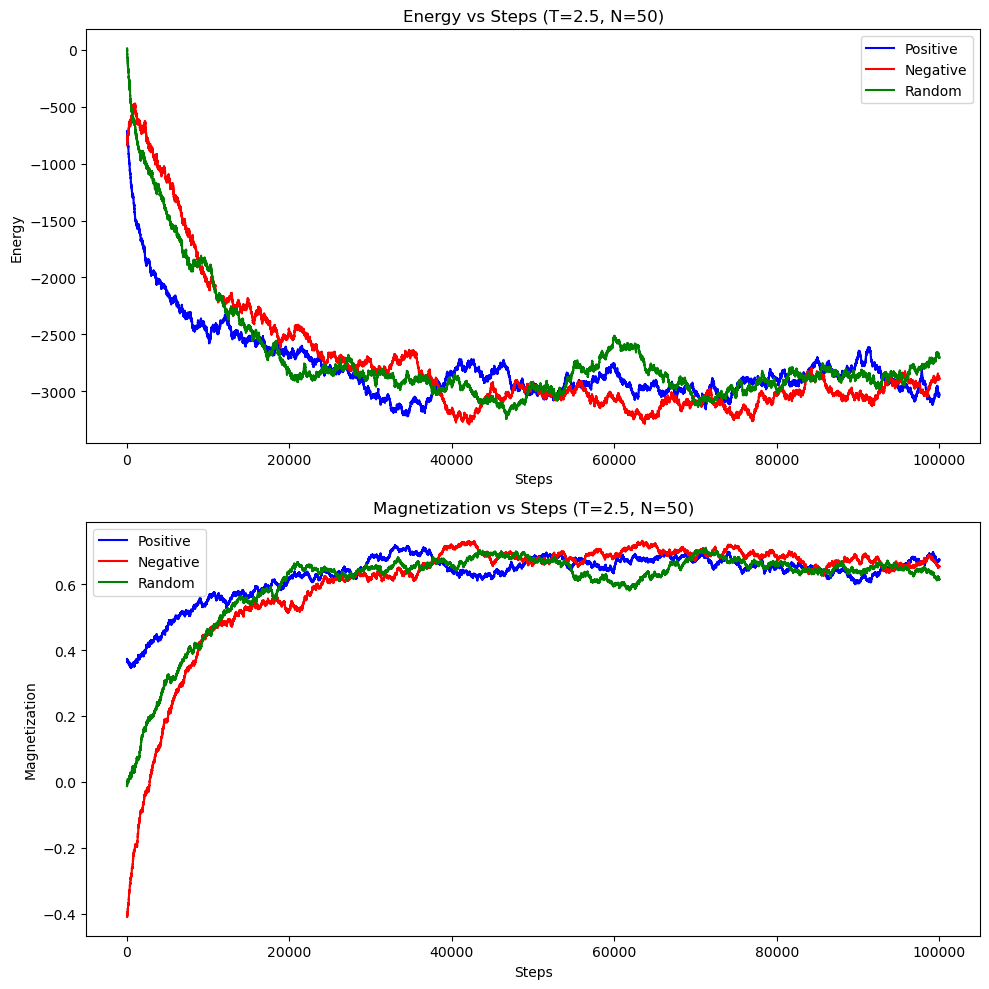

In [69]:
selected_key = 'T2.5_N50'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_2550(data, selected_key)

PRENDIAMO 25000 STEP


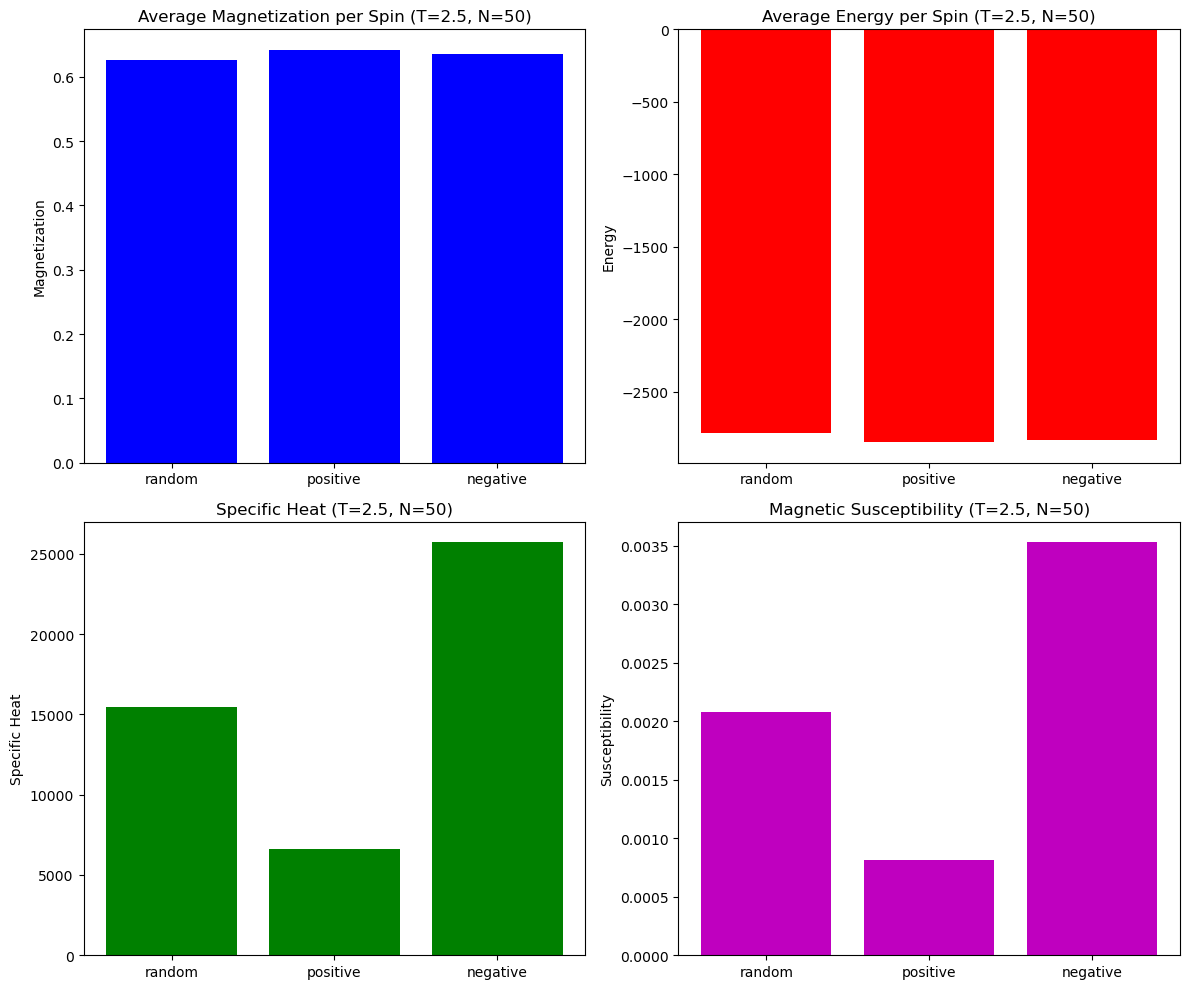

In [70]:
# Parametri
equilibrium_step = 5000  # Questo valore dovrebbe essere determinato precedentemente
T = 2.5  # Temperatura
N = 50  # Dimensione del lattice
selected_key = 'T2.5_N50'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_2550 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_2550, selected_key)

## ANALISI DATI T=2,5 N=100

In [71]:
def plot_data_for_selected_key_2510(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(80000,100000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

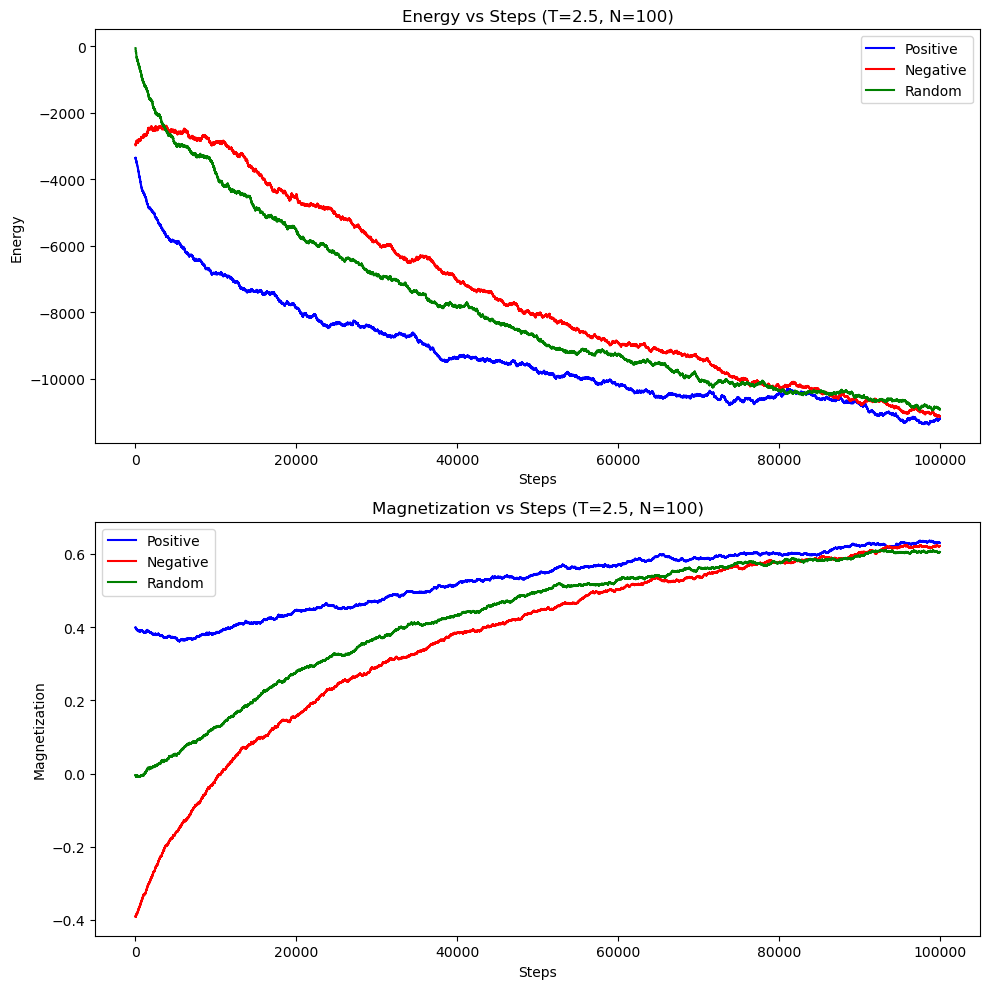

In [72]:
selected_key = 'T2.5_N100'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_2510(data, selected_key)

PRENDIAMO 80000 STEP

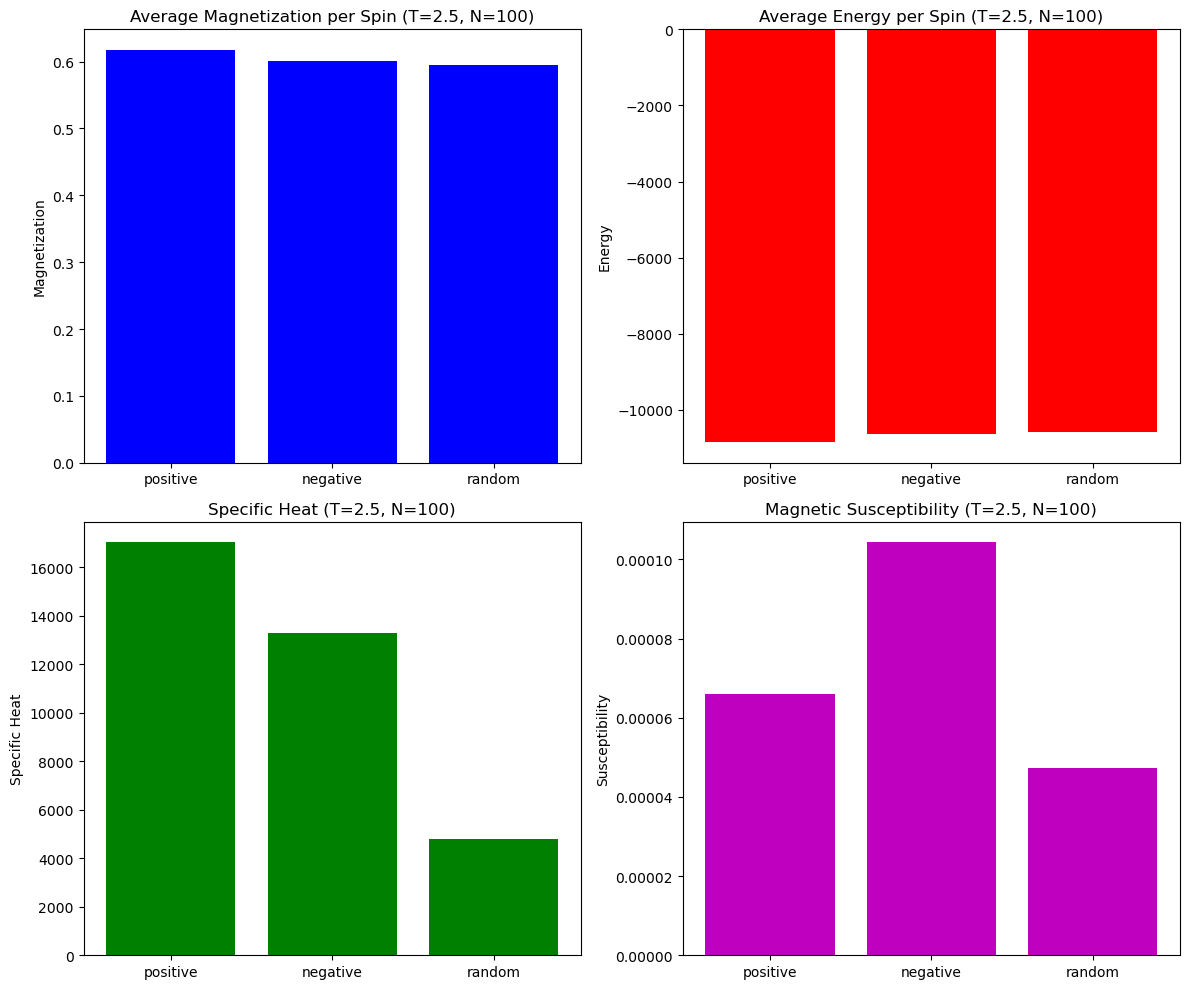

In [73]:
# Parametri
equilibrium_step = 80000  # Questo valore dovrebbe essere determinato precedentemente
T = 2.5  # Temperatura
N = 100  # Dimensione del lattice
selected_key = 'T2.5_N100'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_2510 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_2510, selected_key)

## ANALISI DATI T=3,5 N=25

In [74]:
def plot_data_for_selected_key_3525(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(0,10000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

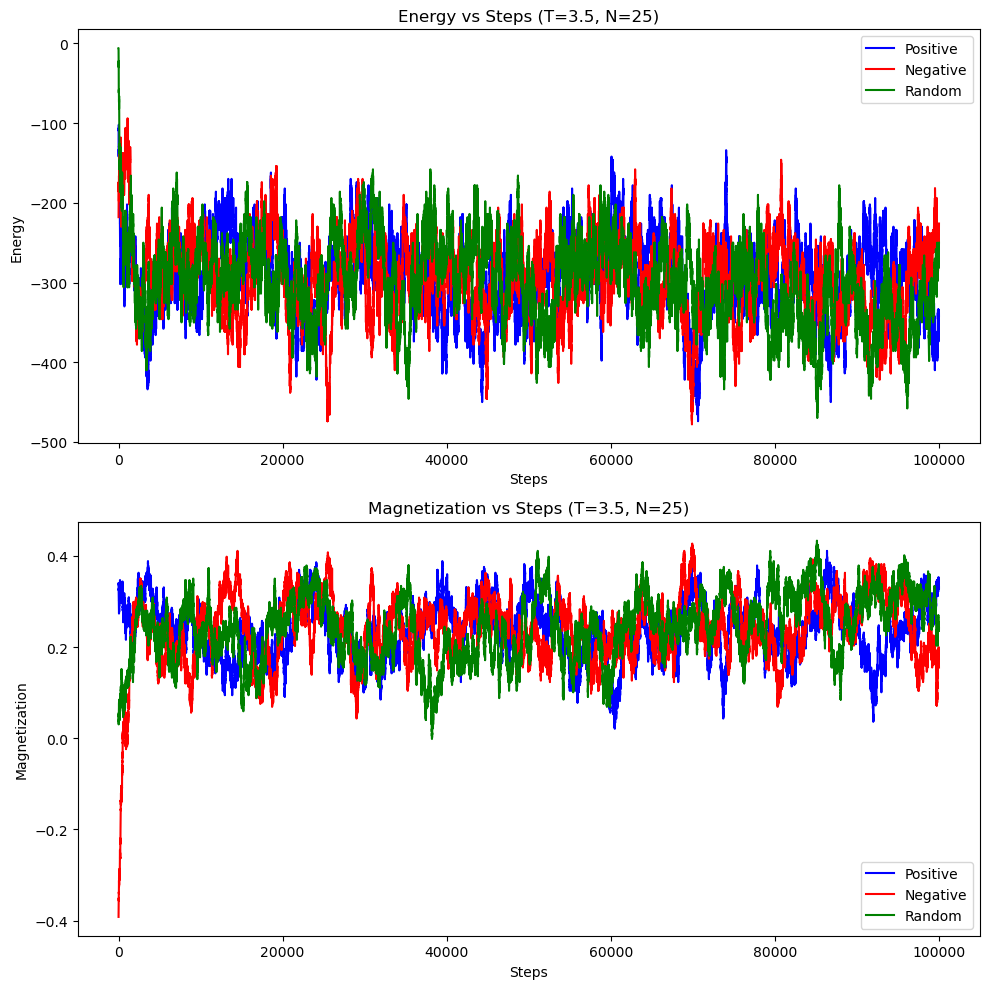

In [75]:
selected_key = 'T3.5_N25'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_3525(data, selected_key)

PRENDIAMO 2000

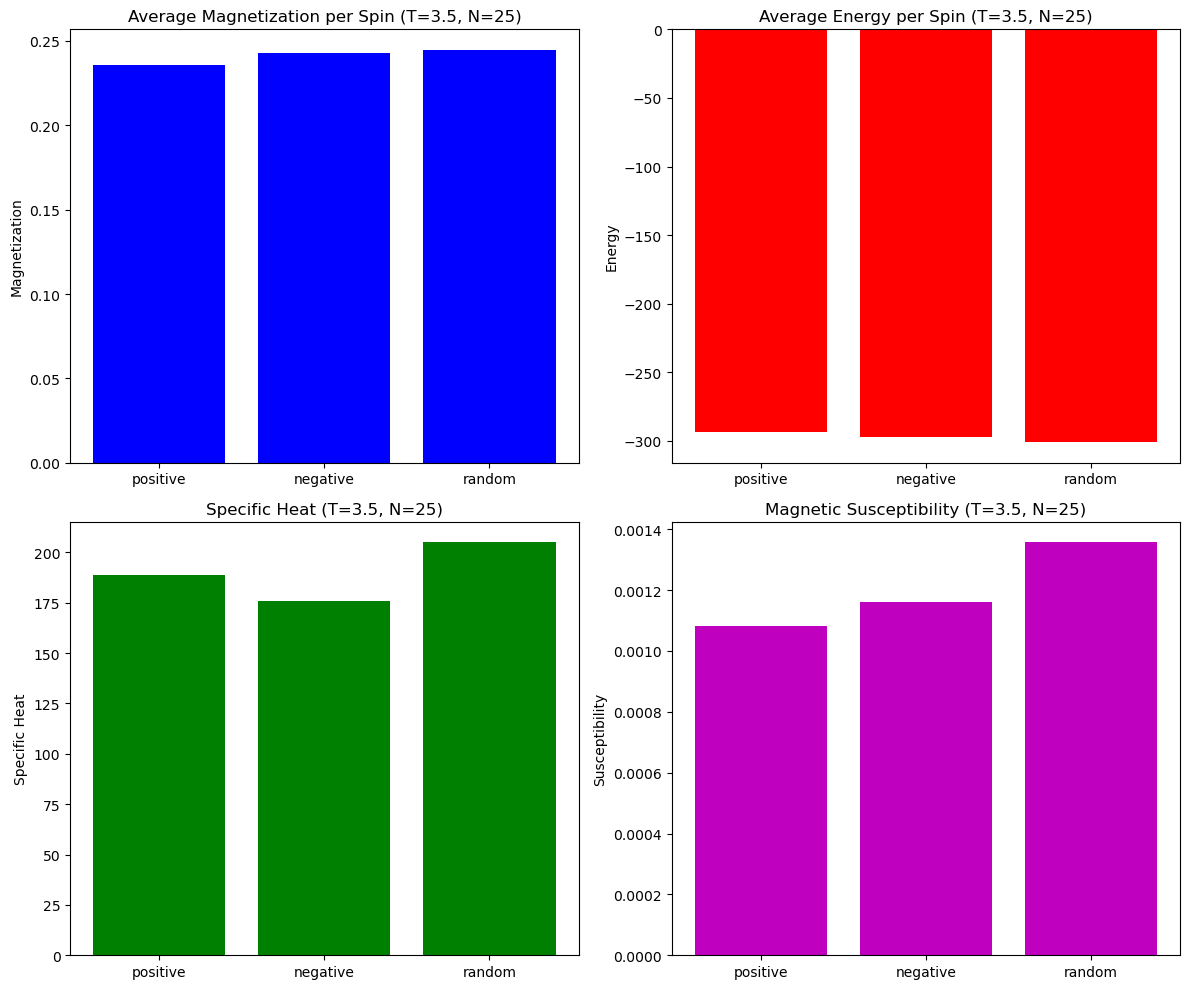

In [76]:
# Parametri
equilibrium_step = 2000  # Questo valore dovrebbe essere determinato precedentemente
T = 3.5  # Temperatura
N = 25  # Dimensione del lattice
selected_key = 'T3.5_N25'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_3525 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_3525, selected_key)

## ANALISI DATI T=3,5 N=50

In [77]:
def plot_data_for_selected_key_3550(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(7500,10000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

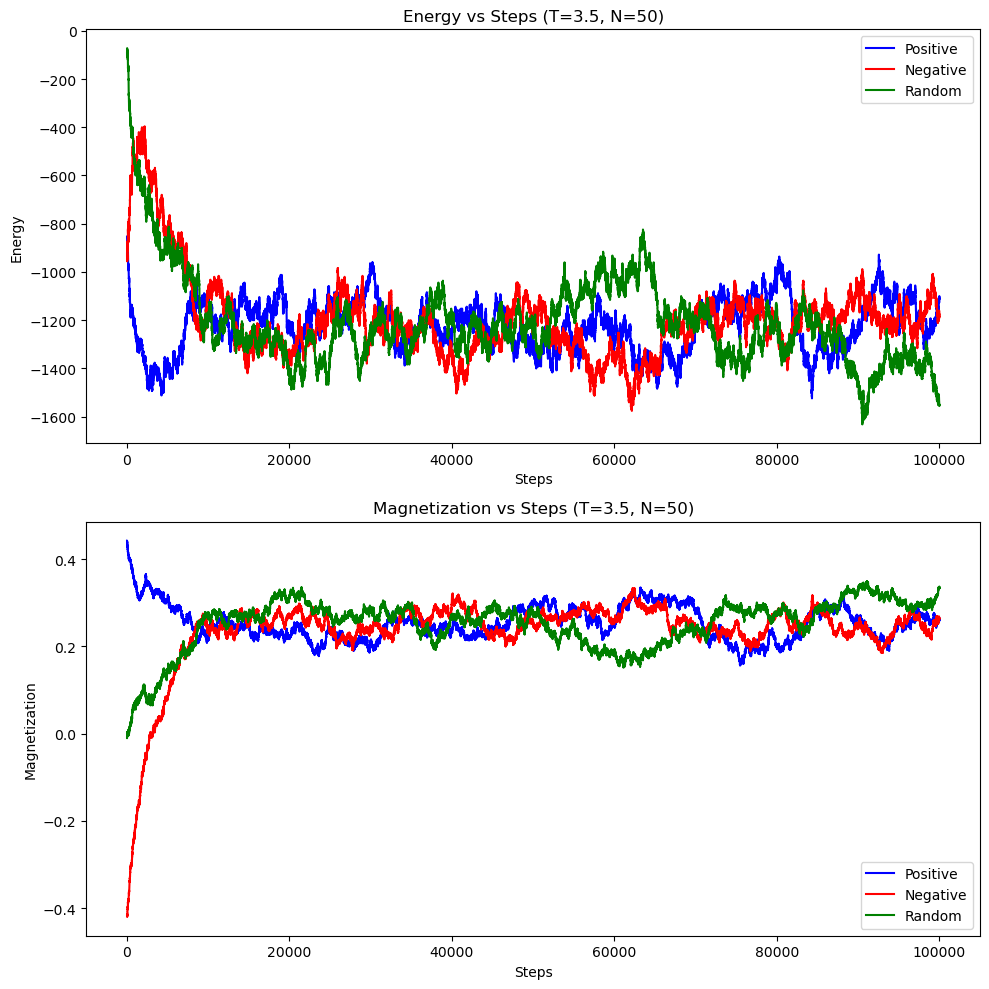

In [78]:
selected_key = 'T3.5_N50'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_3550(data, selected_key)

PRENDIAMO 7500

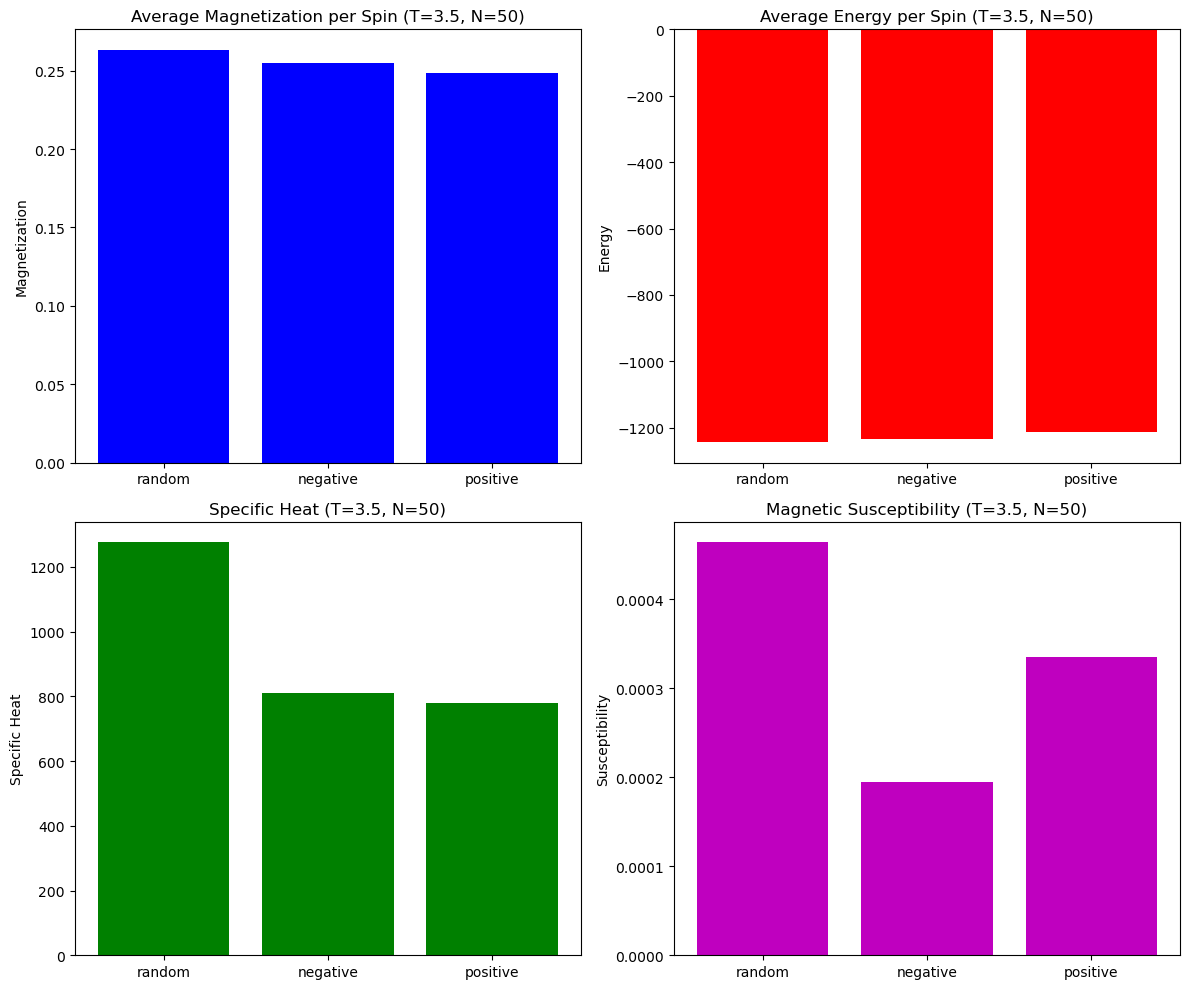

In [79]:
# Parametri
equilibrium_step = 7500  # Questo valore dovrebbe essere determinato precedentemente
T = 3.5  # Temperatura
N = 50  # Dimensione del lattice
selected_key = 'T3.5_N50'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_3550 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_3550, selected_key)

## ANALISI T=3,5 N=100

In [80]:
def plot_data_for_selected_key_3510(data, selected_key):
    # Definizione delle configurazioni e dei colori
    configs = ['positive', 'negative', 'random']
    colors = {'positive': 'b', 'negative': 'r', 'random': 'g'}
    
    # Verifica se la chiave selezionata esiste nei dati
    if selected_key in data:
        # Estrai la temperatura e la dimensione dalla chiave
        temp, size = selected_key.split('_')
        temp = temp[1:]  # Rimuovi il prefisso 'T'
        size = size[1:]  # Rimuovi il prefisso 'N'
        
        # Crea la figura
        plt.figure(figsize=(10, 10))
        
        # Grafico per l'energia
        plt.subplot(2, 1, 1)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['energies'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Energy vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Energy')
        plt.legend()
        
        # Grafico per la magnetizzazione
        plt.subplot(2, 1, 2)
        for config in configs:
            if config in data[selected_key]:
                plt.plot(data[selected_key][config]['steps'], data[selected_key][config]['magnetizations'], 
                         label=f'{config.capitalize()}', color=colors[config])
        plt.title(f'Magnetization vs Steps (T={temp}, N={size})')
        plt.xlabel('Steps')
        plt.ylabel('Magnetization')
        #plt.xlim(30000,50000)
        
        # Aggiungi linee orizzontali e verticali, se necessario
        # plt.axhline(y=1.0, color='gray', linestyle='--', label='Magnetization = 1')
        # plt.axvline(x=6211, color='m', linestyle='-.', label=f'Equilibrium Step = 6211')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f'Data for {selected_key} not found.')

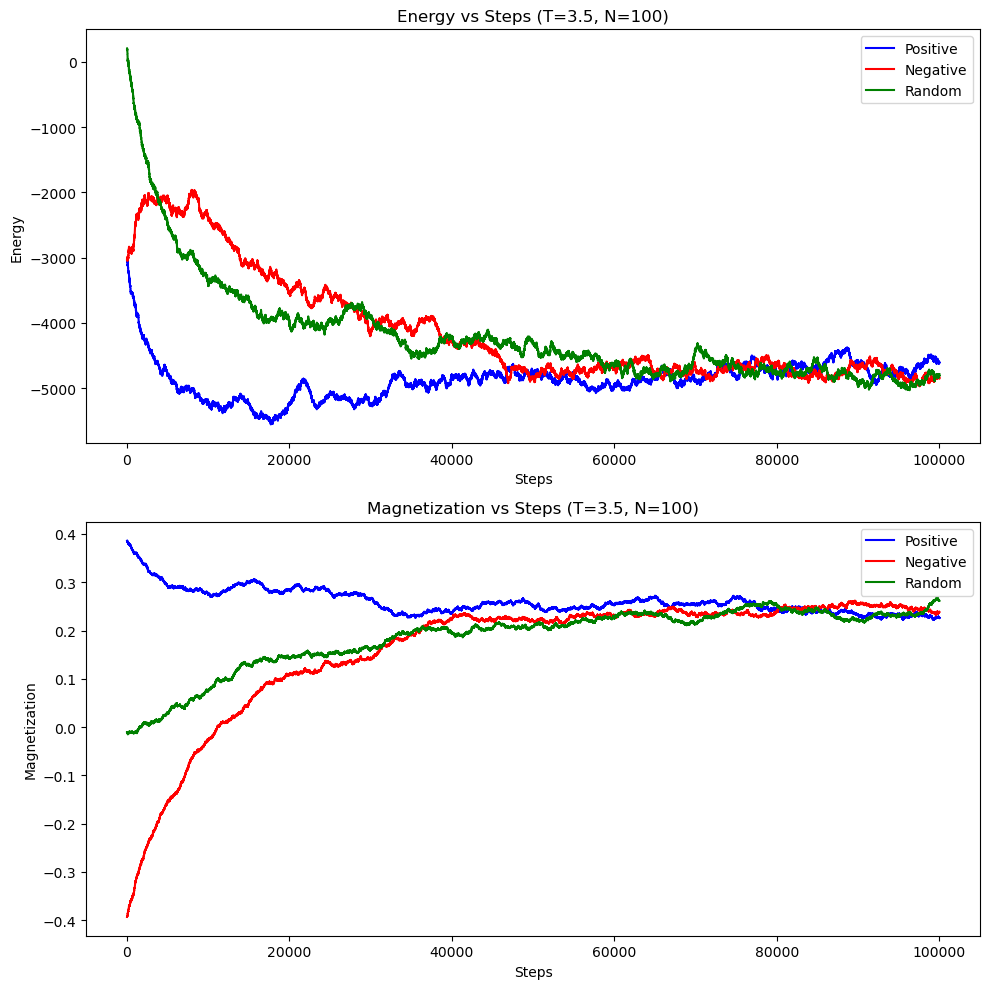

In [81]:
selected_key = 'T3.5_N100'  # Sostituisci con la chiave desiderata
plot_data_for_selected_key_3510(data, selected_key)

PRENDIAMO 40000 STEP

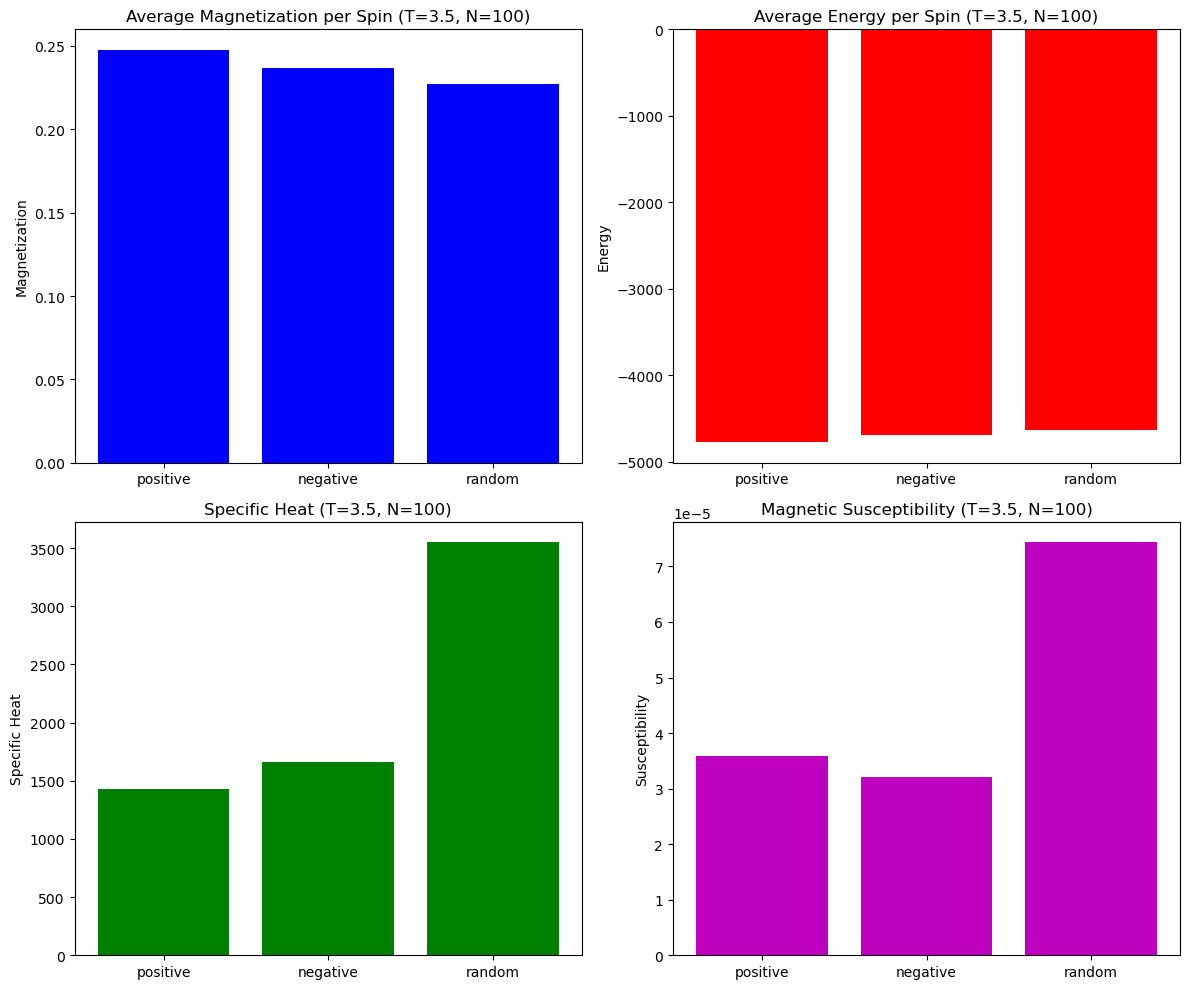

In [82]:
# Parametri
equilibrium_step =40000  # Questo valore dovrebbe essere determinato precedentemente
T = 3.5  # Temperatura
N = 100 # Dimensione del lattice
selected_key = 'T3.5_N100'

# Calcola le medie di ensemble e le fluttuazioni
magnetization_stats_3510 = calculate_ensemble_averages_for_selected_key(data,selected_key, equilibrium_step, T, N)

# Visualizza i risultati
plot_results(magnetization_stats_3510, selected_key)

# ANALISI DATI GENERALE

In [104]:

print(magnetization_stats_3510)

{'T3.5_N100': {'positive': {'average_magnetization': 0.24761334166666663, 'average_energy': -4775.2339, 'specific_heat': 1433.0439529896391, 'susceptibility': 3.5849057047607213e-05}, 'negative': {'average_magnetization': 0.23667014833333333, 'average_energy': -4690.809133333333, 'specific_heat': 1660.4032846190491, 'susceptibility': 3.2051521774666335e-05}, 'random': {'average_magnetization': 0.22699607833333332, 'average_energy': -4632.9492666666665, 'specific_heat': 3548.1208347860647, 'susceptibility': 7.431174027253129e-05}}}


In [ ]:
b

In [105]:
import pandas as pd
# Supponiamo che tu abbia già creato il dizionario, ad esempio:
magnetic_stats_dict = {
    'T1.0_N25': {'random': {'average_magnetization': 0.9994144643828168, 'average_energy': -1248.5592766742368, 'specific_heat': 13.70305367722176, 'susceptibility': 2.298406184375601e-06}, 'positive': {'average_magnetization': 0.9994188486922775, 'average_energy': -1248.5471217306933, 'specific_heat': 10.433387662749738, 'susceptibility': 1.669342025611975e-06}, 'negative': {'average_magnetization': 0.9995066713580485, 'average_energy': -1248.766678395121, 'specific_heat': 9.611993126105517, 'susceptibility': 1.5379189001185622e-06}},
    
    'T1.0_N50': {'negative': {'average_magnetization': 0.9991678270270269, 'average_energy': -4991.814594594594, 'specific_heat': 86.05470592156053, 'susceptibility': 9.034924673967382e-07}, 'positive': {'average_magnetization': 0.9994534162162161, 'average_energy': -4994.586432432432, 'specific_heat': 49.95706997811794, 'susceptibility': 5.21181302670648e-07}, 'random': {'average_magnetization': 0.9993456864864865, 'average_energy': -4993.844756756756, 'specific_heat': 69.20184548199177, 'susceptibility': 9.953203122803345e-07}},
    
    'T1.0_N100': {'positive': {'average_magnetization': 0.9967344299999998, 'average_energy': -19885.0832, 'specific_heat': 1662.6330777406693, 'susceptibility': 1.991004575430111e-06}, 'negative': {'average_magnetization': 0.9866719899999998, 'average_energy': -19559.4811, 'specific_heat': 35830.236742794514, 'susceptibility': 3.617224744023595e-05}, 'random': {'average_magnetization': 0.989501435, 'average_energy': -19663.0765, 'specific_heat': 17759.205147743225, 'susceptibility': 2.2317261940685285e-05}},
    
    'T2.5_N25': {'negative': {'average_magnetization': 0.6676494989473685, 'average_energy': -744.5758315789474, 'specific_heat': 681.3747801419906, 'susceptibility': 0.0012591746864679897}, 'positive': {'average_magnetization': 0.6610240673684212, 'average_energy': -733.6974105263158, 'specific_heat': 772.2900981271267, 'susceptibility': 0.001463036323083511}, 'random': {'average_magnetization': 0.6859467957894736, 'average_energy': -761.7262947368421, 'specific_heat': 709.248584615998, 'susceptibility': 0.0012941180923143226}},
    
    'T2.5_N50': {'random': {'average_magnetization': 0.6267230231578949, 'average_energy': -2785.9335368421052, 'specific_heat': 15476.923736171126, 'susceptibility': 0.0020807261088157556}, 'positive': {'average_magnetization': 0.6416186905263159, 'average_energy': -2846.8534736842107, 'specific_heat': 6631.209822911322, 'susceptibility': 0.0008185415266235285}, 'negative': {'average_magnetization': 0.6346027578947369, 'average_energy': -2834.0134526315787, 'specific_heat': 25701.627039676012, 'susceptibility': 0.0035286621456734222}},
    
    'T2.5_N100': {'positive': {'average_magnetization': 0.6173738049999999, 'average_energy': -10846.8462, 'specific_heat': 17018.8961192894, 'susceptibility': 6.590192192883482e-05}, 'negative': {'average_magnetization': 0.6005723599999999, 'average_energy': -10632.0178, 'specific_heat': 13283.60110130787, 'susceptibility': 0.00010428432081222017}, 'random': {'average_magnetization': 0.59459665, 'average_energy': -10574.5399, 'specific_heat': 4775.25857727766, 'susceptibility': 4.735010671101936e-05}},
    
    'T3.5_N25': {'positive': {'average_magnetization': 0.23567918367346943, 'average_energy': -293.66475510204083, 'specific_heat': 188.9530177960203, 'susceptibility': 0.0010819457565442903}, 'negative': {'average_magnetization': 0.2430001142857143, 'average_energy': -297.2600408163265, 'specific_heat': 176.00088389824046, 'susceptibility': 0.001162141559413176}, 'random': {'average_magnetization': 0.24465497142857145, 'average_energy': -300.8440408163265, 'specific_heat': 204.8517320448466, 'susceptibility': 0.0013563580441338732}},
    
    'T3.5_N50': {'random': {'average_magnetization': 0.2631718486486487, 'average_energy': -1243.2585945945946, 'specific_heat': 1275.5670366617185, 'susceptibility': 0.00046382185060657644}, 'negative': {'average_magnetization': 0.2545727567567568, 'average_energy': -1234.9196108108108, 'specific_heat': 809.8457894989347, 'susceptibility': 0.00019440440829968892}, 'positive': {'average_magnetization': 0.2487056951351351, 'average_energy': -1211.611827027027, 'specific_heat': 780.4353643783882, 'susceptibility': 0.000335248286393215}},
    
    'T3.5_N100': {'positive': {'average_magnetization': 0.24761334166666663, 'average_energy': -4775.2339, 'specific_heat': 1433.0439529896391, 'susceptibility': 3.5849057047607213e-05}, 'negative': {'average_magnetization': 0.23667014833333333, 'average_energy': -4690.809133333333, 'specific_heat': 1660.4032846190491, 'susceptibility': 3.2051521774666335e-05}, 'random': {'average_magnetization': 0.22699607833333332, 'average_energy': -4632.9492666666665, 'specific_heat': 3548.1208347860647, 'susceptibility': 7.431174027253129e-05}}
    
    
}

# Creiamo una lista per contenere tutti i dati
data_list = []

# Iteriamo nel dizionario per popolare la lista
for key, config_data in magnetic_stats_dict.items():
    T = float(key.split('_')[0][1:])  # Estrae la temperatura T
    N = int(key.split('_')[1][1:])    # Estrae la dimensione N
    
    for config, stats in config_data.items():
        row = {
            'T': T,
            'N': N,
            'configuration': config,
            'average_magnetization': stats['average_magnetization'],
            'average_energy': stats['average_energy'],
            'specific_heat': stats['specific_heat'],
            'susceptibility': stats['susceptibility']
        }
        data_list.append(row)

# Converto la lista in un DataFrame pandas
combined_df = pd.DataFrame(data_list)

# Mostra le prime righe del DataFrame combinato
combined_df

,T,N,configuration,average_magnetization,average_energy,specific_heat,susceptibility
0,1.0,25,random,0.999414,-1248.559277,13.703054,2.298406e-06
1,1.0,25,positive,0.999419,-1248.547122,10.433388,1.669342e-06
2,1.0,25,negative,0.999507,-1248.766678,9.611993,1.537919e-06
3,1.0,50,negative,0.999168,-4991.814595,86.054706,9.034925e-07
4,1.0,50,positive,0.999453,-4994.586432,49.957070,5.211813e-07
5,1.0,50,random,0.999346,-4993.844757,69.201845,9.953203e-07
6,1.0,100,positive,0.996734,-19885.083200,1662.633078,1.991005e-06
7,1.0,100,negative,0.986672,-19559.481100,35830.236743,3.617225e-05
8,1.0,100,random,0.989501,-19663.076500,17759.205148,2.231726e-05
9,2.5,25,negative,0.667649,-744.575832,681.374780,1.259175e-03


In [106]:
# Raggruppa il DataFrame per temperatura (T) e dimensione (N)
# e calcola la media delle quantità per ogni gruppo
average = combined_df.groupby(['T', 'N']).mean().reset_index()

# Mostra le prime righe del nuovo DataFrame con i valori medi
average


,T,N,average_magnetization,average_energy,specific_heat,susceptibility
0,1.0,25,0.999447,-1248.624359,11.249478,1.835222e-06
1,1.0,50,0.999322,-4993.415261,68.404540,8.066647e-07
2,1.0,100,0.990969,-19702.546933,18417.358323,2.016017e-05
3,2.5,25,0.671540,-746.666512,720.971154,1.338776e-03
4,2.5,50,0.634315,-2822.266821,15936.586866,2.142643e-03
5,2.5,100,0.604181,-10684.467967,11692.585266,7.251212e-05
6,3.5,25,0.241111,-297.256279,189.935211,1.200148e-03
7,3.5,50,0.255483,-1229.930011,955.282730,3.311582e-04
8,3.5,100,0.237093,-4699.664100,2213.856024,4.740411e-05


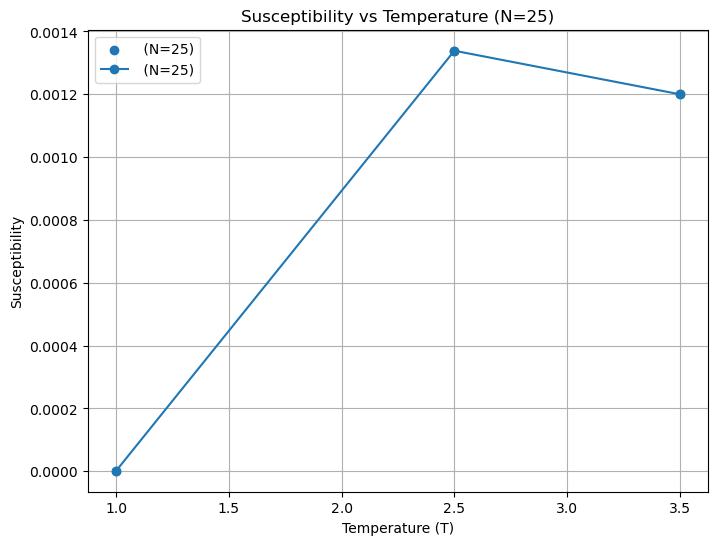

In [107]:
# Filtra il DataFrame per la configurazione 'random' e N=25
average25 = average[ (average['N'] == 25)]

# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average25['T'], average25['susceptibility'], marker='o', label=' (N=25)')
plt.plot(average25['T'], average25['susceptibility'], marker='o', label=' (N=25)')
plt.title('Susceptibility vs Temperature (N=25)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

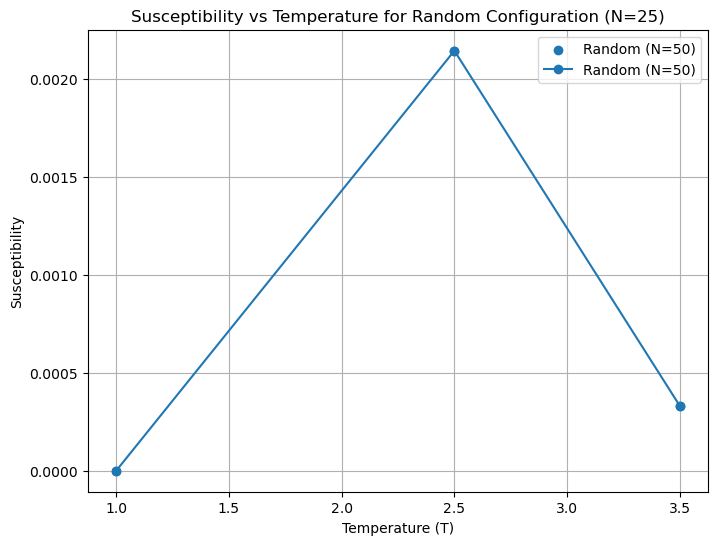

In [108]:
# Filtra il DataFrame per la configurazione 'random' e N=25
average50 = average[ (average['N'] == 50)]

# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average50['T'], average50['susceptibility'], marker='o', label='Random (N=50)')
plt.plot(average50['T'], average50['susceptibility'], marker='o', label='Random (N=50)')
plt.title('Susceptibility vs Temperature for Random Configuration (N=25)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

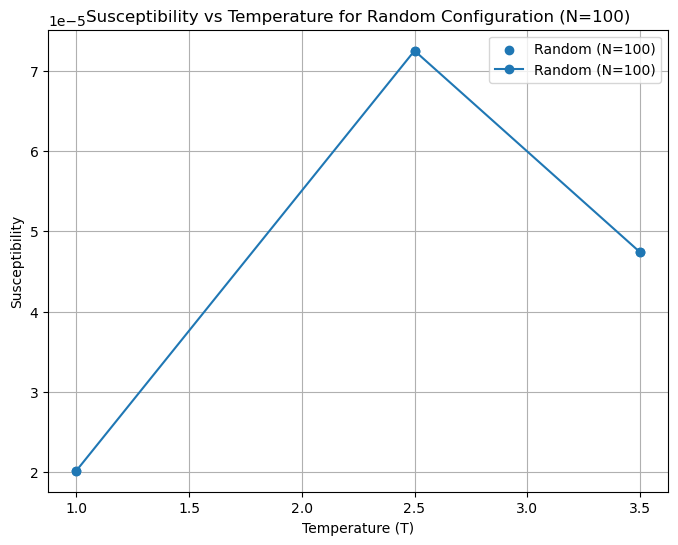

In [109]:
# Filtra il DataFrame per la configurazione 'random' e N=25
average10 = average[(average['N'] == 100)]

# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average10['T'], average10['susceptibility'], marker='o', label='Random (N=100)')
plt.plot(average10['T'], average10['susceptibility'], marker='o', label='Random (N=100)')
plt.title('Susceptibility vs Temperature for Random Configuration (N=100)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

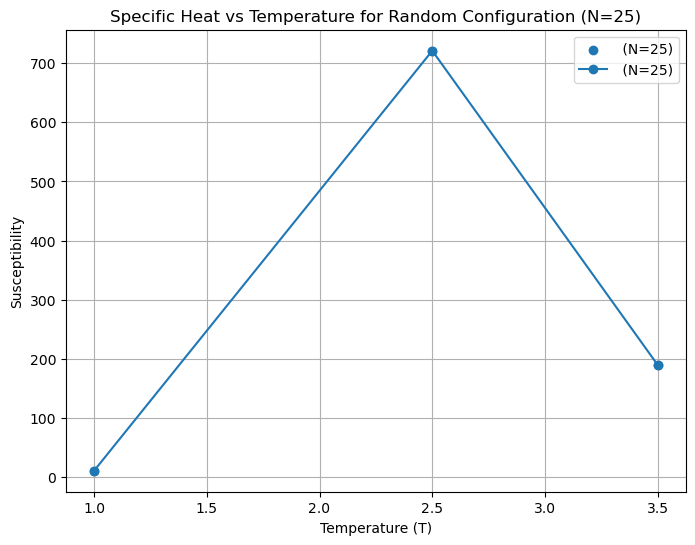

In [110]:
# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average25['T'],average25['specific_heat'], marker='o', label=' (N=25)')
plt.plot(average25['T'], average25['specific_heat'], marker='o', label=' (N=25)')
plt.title('Specific Heat vs Temperature for Random Configuration (N=25)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

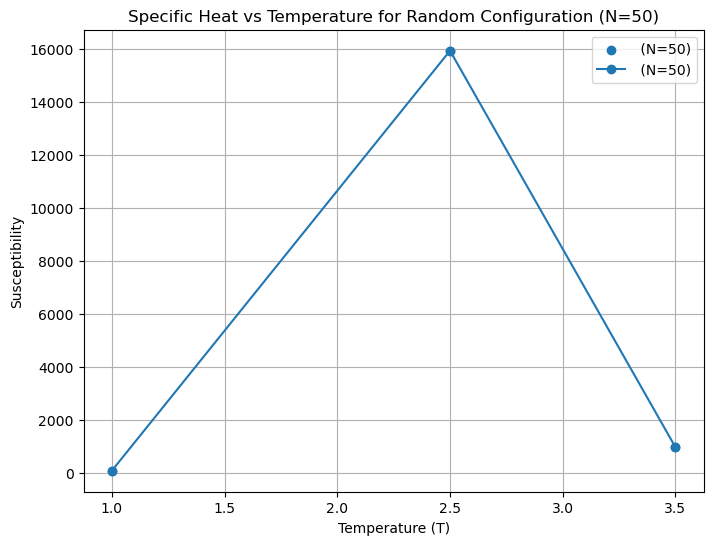

In [111]:
# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average50['T'],average50['specific_heat'], marker='o', label=' (N=50)')
plt.plot(average50['T'], average50['specific_heat'], marker='o', label=' (N=50)')
plt.title('Specific Heat vs Temperature for Random Configuration (N=50)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

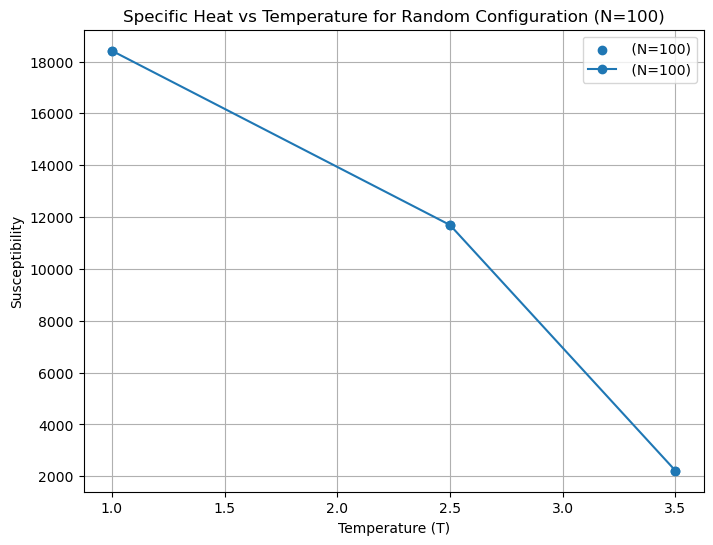

In [112]:
# Crea il grafico per la suscettibilità in funzione della temperatura
plt.figure(figsize=(8, 6))
plt.scatter(average10['T'],average10['specific_heat'], marker='o', label=' (N=100)')
plt.plot(average10['T'], average10['specific_heat'], marker='o', label=' (N=100)')
plt.title('Specific Heat vs Temperature for Random Configuration (N=100)')
plt.xlabel('Temperature (T)')
plt.ylabel('Susceptibility')
plt.legend()
plt.grid(True)
plt.show()

## integrated correlation time and critical slowing down

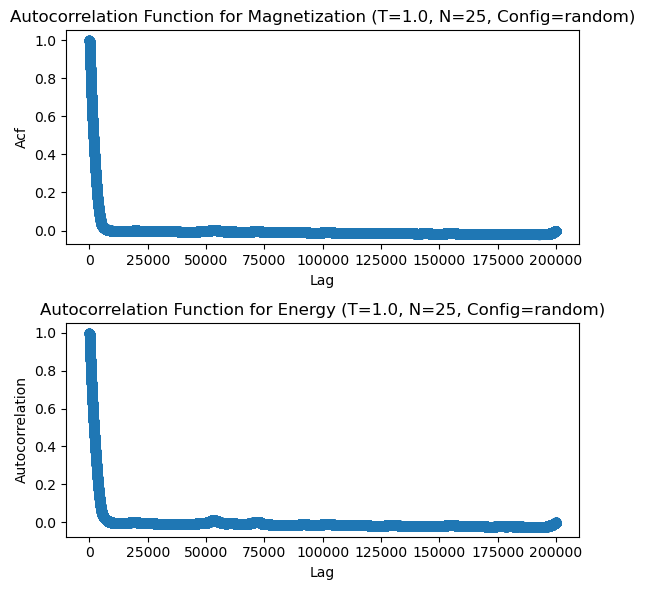

Autocorrelation time for Magnetization (T=1.0, N=25, Config=random): 4608
Autocorrelation time for Energy (T=1.0, N=25, Config=random): 5282


KeyboardInterrupt: 

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import re

# Funzione per calcolare la funzione di autocorrelazione
def autocorrelation(x):
    """Compute the autocorrelation function of a time series."""
    n = len(x)
    mean_x = np.mean(x)
    var_x = np.var(x)
    autocorr = np.correlate(x - mean_x, x - mean_x, mode='full') / (var_x * n)
    return autocorr[n - 1:]

# Funzione per stimare il tempo di autocorrelazione (τ) come il punto dove C(t) = 1/e
def estimate_tau(acf):
    """Estimate tau as the time where the autocorrelation function falls to 1/e."""
    threshold = 1 / np.e
    for t, ac in enumerate(acf):
        if ac < threshold:
            return t
    return len(acf)  # Return max length if not found

# Funzione per stimare il tempo di autocorrelazione integrata (τ_intO)
def autocorrelation_time(acf):
    """Estimate the integrated autocorrelation time."""
    tau = estimate_tau(acf)
    return 2 * tau  # According to the formula τ_intO ≈ 2 * τ


# Funzione per stimare e tracciare il tempo di autocorrelazione
def plot_autocorrelation(data):
    for key in data:
        for config in data[key]:
            magnetizations = np.array(data[key][config]['magnetizations'])
            energies = np.array(data[key][config]['energies'])
            
            # Calcola e traccia per la magnetizzazione
            acf_mag = autocorrelation(magnetizations)
            ac_time_mag = autocorrelation_time(acf_mag)
            
            plt.figure(figsize=(6, 6))
            plt.subplot(2, 1, 1)
            plt.plot(acf_mag, marker='o')
            plt.title(f'Autocorrelation Function for Magnetization (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config})')
            plt.xlabel('Lag')
            plt.ylabel('Acf')
            
            # Calcola e traccia per l'energia
            acf_ene = autocorrelation(energies)
            ac_time_ene = autocorrelation_time(acf_ene)
            
            plt.subplot(2, 1, 2)
            plt.plot(acf_ene, marker='o')
            plt.title(f'Autocorrelation Function for Energy (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config})')
            plt.xlabel('Lag')
            plt.ylabel('Autocorrelation')
            
            plt.tight_layout()
            plt.show()
            
            print(f'Autocorrelation time for Magnetization (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config}): {ac_time_mag}')
            print(f'Autocorrelation time for Energy (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config}): {ac_time_ene}')

# Esempio di utilizzo:
sorted_files = sort_files('dati_file_txt/ising_data_T*.txt')
data = read_data_1(sorted_files)
plot_autocorrelation(data)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Funzione per calcolare la funzione di autocorrelazione
def autocorrelation(x):
    """Compute the autocorrelation function of a time series."""
    n = len(x)
    mean_x = np.mean(x)
    var_x = np.var(x)
    autocorr = np.correlate(x - mean_x, x - mean_x, mode='full') / (var_x * n)
    return autocorr[n - 1:]

# Funzione per stimare il tempo di autocorrelazione (τ) come il punto dove C(t) = 1/e
def estimate_tau(acf):
    """Estimate tau as the time where the autocorrelation function falls to 1/e."""
    threshold = 1 / np.e
    for t, ac in enumerate(acf):
        if ac < threshold:
            return t
    return len(acf)  # Return max length if not found

# Funzione per stimare il tempo di autocorrelazione integrata (τ_intO)
def autocorrelation_time(acf):
    """Estimate the integrated autocorrelation time."""
    tau = estimate_tau(acf)
    return 2 * tau  # According to the formula τ_intO ≈ 2 * τ

# Funzione per stimare e tracciare il tempo di autocorrelazione
def plot_autocorrelation(data):
    tau_int_results = []
    
    for key in data:
        for config in data[key]:
            magnetizations = np.array(data[key][config]['magnetizations'])
            energies = np.array(data[key][config]['energies'])
            
            # Calcola e traccia per la magnetizzazione
            acf_mag = autocorrelation(magnetizations)
            ac_time_mag = autocorrelation_time(acf_mag)
            
            # Calcola e traccia per l'energia
            acf_ene = autocorrelation(energies)
            ac_time_ene = autocorrelation_time(acf_ene)
            
            tau_int_results.append({
                'T': float(key.split("_")[0][1:]),
                'N': int(key.split("_")[1][1:]),
                f'tau_int_mag_{config}': ac_time_mag,
                f'tau_int_ene_{config}': ac_time_ene
            })
            
            plt.figure(figsize=(6, 6))
            plt.subplot(2, 1, 1)
            plt.plot(acf_mag, marker='o')
            plt.title(f'Autocorrelation Function for Magnetization (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config})')
            plt.xlabel('Lag')
            plt.ylabel('Acf')
            
            plt.subplot(2, 1, 2)
            plt.plot(acf_ene, marker='o')
            plt.title(f'Autocorrelation Function for Energy (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config})')
            plt.xlabel('Lag')
            plt.ylabel('Autocorrelation')
            
            plt.tight_layout()
            plt.show()
            
            print(f'Autocorrelation time for Magnetization (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config}): {ac_time_mag}')
            print(f'Autocorrelation time for Energy (T={key.split("_")[0][1:]}, N={key.split("_")[1][1:]}, Config={config}): {ac_time_ene}')
    
    return pd.DataFrame(tau_int_results)

# Esempio di utilizzo
sorted_files = sort_files('dati_file_txt/ising_data_T*.txt')
data = read_data_1(sorted_files)

# Calcola i tempi di autocorrelazione e restituisce un DataFrame
tau_int_df = plot_autocorrelation(data)

# Supponiamo che 'df' sia il tuo DataFrame originale
df = pd.DataFrame({
    'T': [1.0, 1.0, 1.0, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5],
    'N': [25, 50, 100, 25, 50, 100, 25, 50, 100],
    'average_magnetization': [0.999447, 0.999322, 0.990969, 0.671540, 0.634315, 0.604181, 0.241111, 0.255483, 0.237093],
    'average_energy': [-1248.624359, -4993.415261, -19702.546933, -746.666512, -2822.266821, -10684.467967, -297.256279, -1229.930011, -4699.664100],
    'specific_heat': [0.449979, 1.368091, 184.173583, 28.838846, 318.731737, 116.925853, 7.597408, 19.105655, 22.138560],
    'susceptibility': [7.340889e-08, 1.613329e-08, 2.016017e-07, 5.355105e-05, 4.285287e-05, 7.251212e-07, 4.800594e-05, 6.623164e-06, 4.740411e-07]
})

# Unisce i risultati dei tempi di autocorrelazione con il DataFrame originale
df = pd.merge(df, tau_int_df, on=['T', 'N'], how='left')

print(df)


In [ ]:
df

per vedere il critical slowing down dobbiamo guardare se il tempo per la temperatura vicino a quella critica è molto più lungo dell'altro 

## Finite-size analysis and estimates of the critical exponents

In [115]:
average

,T,N,average_magnetization,average_energy,specific_heat,susceptibility
0,1.0,25,0.999447,-1248.624359,11.249478,1.835222e-06
1,1.0,50,0.999322,-4993.415261,68.404540,8.066647e-07
2,1.0,100,0.990969,-19702.546933,18417.358323,2.016017e-05
3,2.5,25,0.671540,-746.666512,720.971154,1.338776e-03
4,2.5,50,0.634315,-2822.266821,15936.586866,2.142643e-03
5,2.5,100,0.604181,-10684.467967,11692.585266,7.251212e-05
6,3.5,25,0.241111,-297.256279,189.935211,1.200148e-03
7,3.5,50,0.255483,-1229.930011,955.282730,3.311582e-04
8,3.5,100,0.237093,-4699.664100,2213.856024,4.740411e-05


     N   Tc
0   25  2.5
1   50  2.5
2  100  2.5
Estimativa di beta / nu: 2.0811418514540443
Estimativa di alpha / nu: -0.6135425313352254


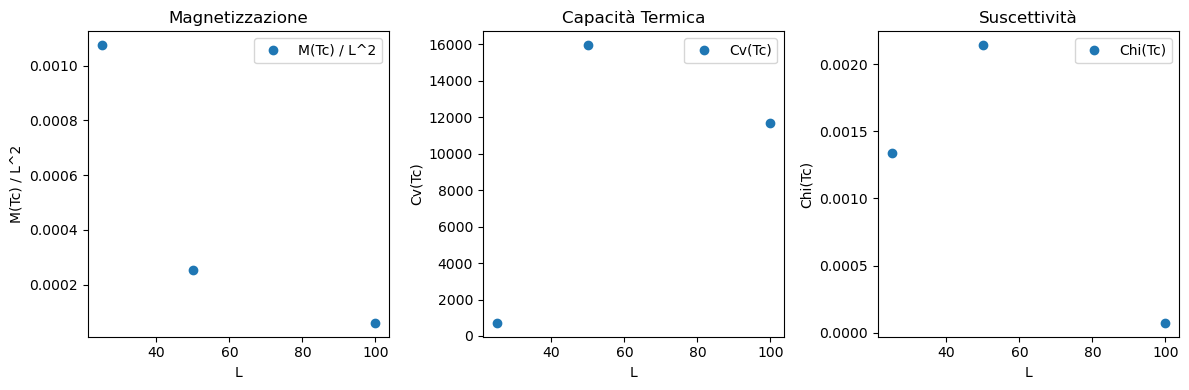

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit



# Funzione per trovare Tc(L) come 2.5 per ogni dimensione L
def find_Tc(df, fixed_temp=2.5):
    Tc = []
    for N in df['N'].unique():
        subset = df[(df['N'] == N) & (df['T'] == fixed_temp)]
        if not subset.empty:
            T_max_Cv = fixed_temp  # Poiché T è fissato a 2.5
            Tc.append((N, T_max_Cv))
    return pd.DataFrame(Tc, columns=['N', 'Tc'])

# Trova Tc(L)
Tc_df = find_Tc(average)
print(Tc_df)

# Calcola M(T) / L^(beta / nu) e Cv(Tc) per diverse dimensioni
def power_law(x, a, b):
    return a * x**b

# Prepara i dati per l'adattamento
L_values = df['N'].unique()
Tc_values = Tc_df['Tc']
Cv_at_Tc = [df[(df['N'] == L) & (df['T'] == Tc)]['specific_heat'].values[0] for L, Tc in zip(L_values, Tc_values)]
M_at_Tc = [df[(df['N'] == L) & (df['T'] == Tc)]['average_magnetization'].values[0] for L, Tc in zip(L_values, Tc_values)]

# Adatta la legge di potenza per stimare beta / nu
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(L_values, M_at_Tc / L_values**2, 'o', label='M(Tc) / L^2')
plt.xlabel('L')
plt.ylabel('M(Tc) / L^2')
plt.title('Magnetizzazione')
plt.legend()

# Adatta una legge di potenza
params, _ = curve_fit(power_law, L_values, M_at_Tc / L_values**2)
beta_over_nu = -params[1]
print(f'Estimativa di beta / nu: {beta_over_nu}')

plt.subplot(1, 3, 2)
plt.plot(L_values, Cv_at_Tc, 'o', label='Cv(Tc)')
plt.xlabel('L')
plt.ylabel('Cv(Tc)')
plt.title('Capacità Termica')
plt.legend()

# Adatta una legge di potenza per alpha / nu
params, _ = curve_fit(power_law, L_values, Cv_at_Tc)
alpha_over_nu = -params[1]
print(f'Estimativa di alpha / nu: {alpha_over_nu}')

plt.subplot(1, 3, 3)
plt.plot(L_values, df[df['T'] == Tc_values.iloc[0]]['susceptibility'].values, 'o', label='Chi(Tc)')
plt.xlabel('L')
plt.ylabel('Chi(Tc)')
plt.title('Suscettività')
plt.legend()

plt.tight_layout()
plt.show()


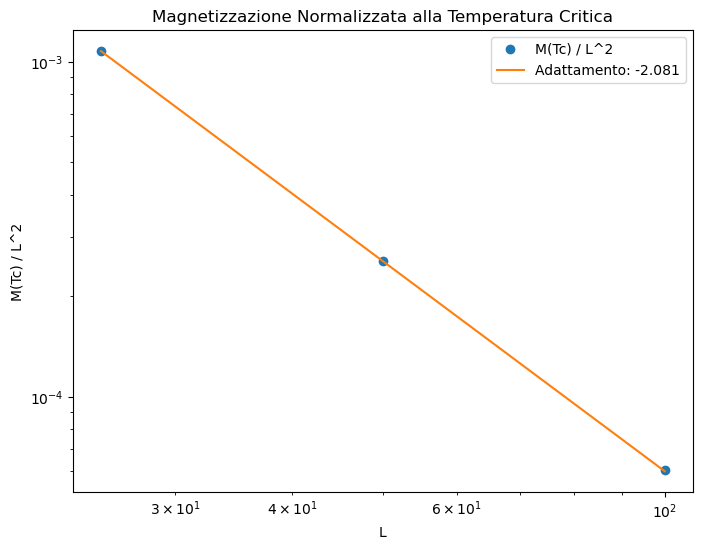

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Funzione di legge di potenza
def power_law(x, a, b):
    return a * x**b

# Dati di esempio
L_values = np.array([25, 50, 100])
M_at_Tc = np.array([0.671540, 0.634315, 0.604181])  # Magnetizzazione alla Tc

# Normalizzazione
M_at_Tc_normalized = M_at_Tc / L_values**2

# Adatta la legge di potenza
params_M, _ = curve_fit(power_law, L_values, M_at_Tc_normalized)

# Grafico
plt.figure(figsize=(8, 6))
plt.plot(L_values, M_at_Tc_normalized, 'o', label='M(Tc) / L^2')
plt.plot(L_values, power_law(L_values, *params_M), '-', label=f'Adattamento: {params_M[1]:.3f}')
plt.xlabel('L')
plt.ylabel('M(Tc) / L^2')
plt.title('Magnetizzazione Normalizzata alla Temperatura Critica')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Sample data, replace this with your DataFrame
df = pd.DataFrame({
    'T': [1.0, 1.0, 1.0, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5],
    'N': [25, 50, 100, 25, 50, 100, 25, 50, 100],
    'average_magnetization': [0.999447, 0.999322, 0.990969, 0.671540, 0.634315, 0.604181, 0.241111, 0.255483, 0.237093],
    'average_energy': [-1248.624359, -4993.415261, -19702.546933, -746.666512, -2822.266821, -10684.467967, -297.256279, -1229.930011, -4699.664100],
    'specific_heat': [0.449979, 1.368091, 184.173583, 28.838846, 318.731737, 116.925853, 7.597408, 19.105655, 22.138560],
    'susceptibility': [7.340889e-08, 1.613329e-08, 2.016017e-07, 5.355105e-05, 4.285287e-05, 7.251212e-07, 4.800594e-05, 6.623164e-06, 4.740411e-07]
})

# Define a function for power law fitting
def power_law(x, a, b,c):
    return c+a * x**b

# Extract unique sizes and their corresponding values at T_c
L_values = df['N'].unique()
Cv_at_Tc = df[df['T'] == 2.5].groupby('N')['specific_heat'].mean().values
M_at_Tc = df[df['T'] == 2.5].groupby('N')['average_magnetization'].mean().values

# Fit for magnetization
params_M, _ = curve_fit(power_law, L_values, M_at_Tc / L_values**(2), p0=[1, -1,0])
beta_over_nu = -params_M[1]
print(f'Estimativa di beta / nu: {beta_over_nu}')

# Fit for specific heat
params_Cv, _ = curve_fit(power_law, L_values, Cv_at_Tc, p0=[1, 1])
alpha_over_nu = -params_Cv[1]
print(f'Estimativa di alpha / nu: {alpha_over_nu}')

# Plot results
plt.figure(figsize=(12, 6))

# Magnetization plot
plt.subplot(1, 2, 1)
plt.plot(L_values, M_at_Tc / L_values**2, 'o', label='M(Tc) / L^2')
plt.xlabel('L')
plt.ylabel('M(Tc) / L^2')
plt.title('Magnetizzazione')
plt.legend()

# Specific heat plot
plt.subplot(1, 2, 2)
plt.plot(L_values, Cv_at_Tc, 'o', label='Cv(Tc)')
plt.xlabel('L')
plt.ylabel('Cv(Tc)')
plt.title('Capacità Termica')
plt.legend()

plt.tight_layout()
plt.show()


Estimativa di beta / nu: 2.0860211533119783


/var/folders/_b/dwnrhdgd0y7_7nj2zgdrqt6m0000gq/T/ipykernel_16809/1345784621.py:18: RuntimeWarning: invalid value encountered in reciprocal
  return c+a * x**b
/Users/annagarbo1/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


TypeError: power_law() missing 1 required positional argument: 'c'

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Supponiamo che 'df' sia il tuo DataFrame
df = pd.DataFrame({
    'T': [1.0, 1.0, 1.0, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5],
    'N': [25, 50, 100, 25, 50, 100, 25, 50, 100],
    'average_magnetization': [0.999447, 0.999322, 0.990969, 0.671540, 0.634315, 0.604181, 0.241111, 0.255483, 0.237093],
    'average_energy': [-1248.624359, -4993.415261, -19702.546933, -746.666512, -2822.266821, -10684.467967, -297.256279, -1229.930011, -4699.664100],
    'specific_heat': [0.449979*25, 1.368091, 184.173583, 28.838846, 318.731737, 116.925853, 7.597408, 19.105655, 22.138560],
    'susceptibility': [7.340889e-08, 1.613329e-08, 2.016017e-07, 5.355105e-05, 4.285287e-05, 7.251212e-07, 4.800594e-05, 6.623164e-06, 4.740411e-07]
})


,T,N,average_magnetization,average_energy,specific_heat,susceptibility
0,1.0,25,0.999447,-1248.624359,11.249475,7.340889e-08
1,1.0,50,0.999322,-4993.415261,1.368091,1.613329e-08
2,1.0,100,0.990969,-19702.546933,184.173583,2.016017e-07
3,2.5,25,0.671540,-746.666512,28.838846,5.355105e-05
4,2.5,50,0.634315,-2822.266821,318.731737,4.285287e-05
5,2.5,100,0.604181,-10684.467967,116.925853,7.251212e-07
6,3.5,25,0.241111,-297.256279,7.597408,4.800594e-05
7,3.5,50,0.255483,-1229.930011,19.105655,6.623164e-06
8,3.5,100,0.237093,-4699.664100,22.138560,4.740411e-07


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Suppose 'df' is your DataFrame
df = pd.DataFrame({
    'T': [1.0, 1.0, 1.0, 2.5, 2.5, 2.5, 3.5, 3.5, 3.5],
    'N': [25, 50, 100, 25, 50, 100, 25, 50, 100],
    'average_magnetization': [0.999447, 0.999322, 0.990969, 0.671540, 0.634315, 0.604181, 0.241111, 0.255483, 0.237093],
    'average_energy': [-1248.624359, -4993.415261, -19702.546933, -746.666512, -2822.266821, -10684.467967, -297.256279, -1229.930011, -4699.664100],
    'specific_heat': [0.449979, 1.368091, 184.173583, 28.838846, 318.731737, 116.925853, 7.597408, 19.105655, 22.138560],
    'susceptibility': [7.340889e-08, 1.613329e-08, 2.016017e-07, 5.355105e-05, 4.285287e-05, 7.251212e-07, 4.800594e-05, 6.623164e-06, 4.740411e-07]
})

# Multiply 'specific_heat' and 'susceptibility' by 'N'
df['specific_heat'] = df['specific_heat'] * df['N']
df['susceptibility'] = df['susceptibility'] * df['N']

# Display the modified DataFrame
df


,T,N,average_magnetization,average_energy,specific_heat,susceptibility
0,1.0,25,0.999447,-1248.624359,11.249475,1.835222e-06
1,1.0,50,0.999322,-4993.415261,68.404550,8.066645e-07
2,1.0,100,0.990969,-19702.546933,18417.358300,2.016017e-05
3,2.5,25,0.671540,-746.666512,720.971150,1.338776e-03
4,2.5,50,0.634315,-2822.266821,15936.586850,2.142644e-03
5,2.5,100,0.604181,-10684.467967,11692.585300,7.251212e-05
6,3.5,25,0.241111,-297.256279,189.935200,1.200149e-03
7,3.5,50,0.255483,-1229.930011,955.282750,3.311582e-04
8,3.5,100,0.237093,-4699.664100,2213.856000,4.740411e-05


     N   Tc
0   25  2.5
1   50  2.5
2  100  2.5
Estimativa di beta / nu: 2.0811418514540443
Estimativa di alpha / nu: -0.6135425313352254


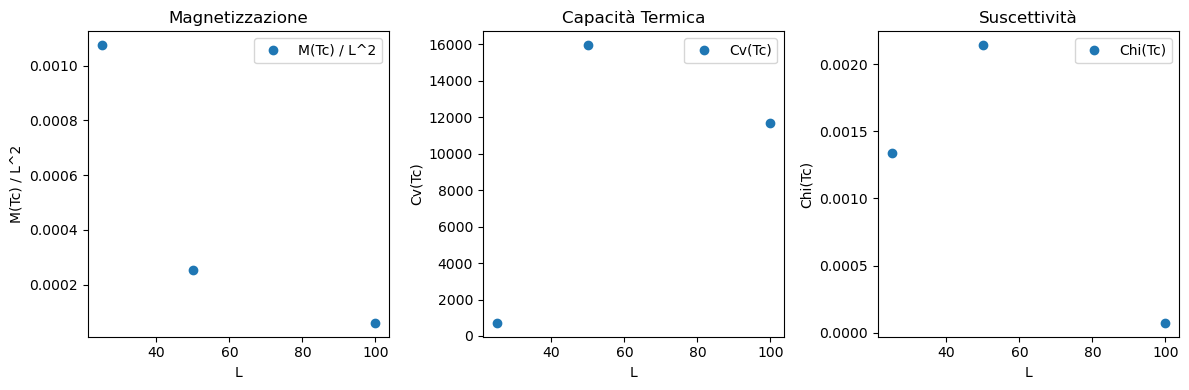

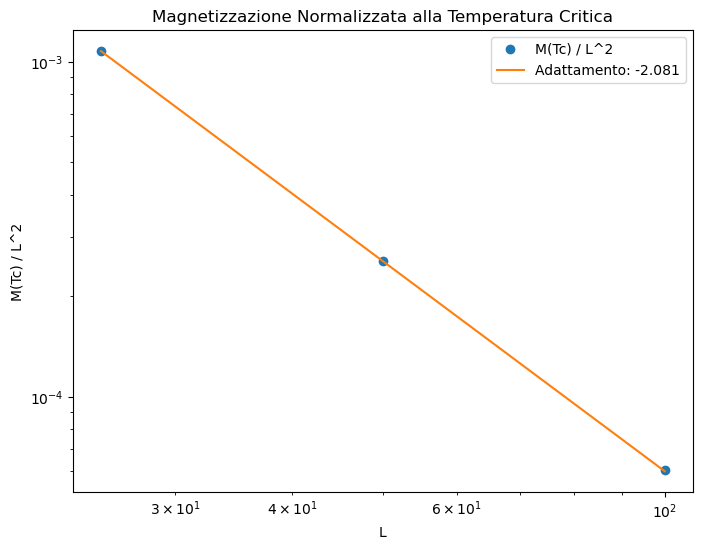

In [52]:
# Funzione per trovare Tc(L) come 2.5 per ogni dimensione L
def find_Tc(df, fixed_temp=2.5):
    Tc = []
    for N in df['N'].unique():
        subset = df[(df['N'] == N) & (df['T'] == fixed_temp)]
        if not subset.empty:
            T_max_Cv = fixed_temp  # Poiché T è fissato a 2.5
            Tc.append((N, T_max_Cv))
    return pd.DataFrame(Tc, columns=['N', 'Tc'])

# Trova Tc(L)
Tc_df = find_Tc(df)
print(Tc_df)

# Calcola M(T) / L^(beta / nu) e Cv(Tc) per diverse dimensioni
def power_law(x, a, b):
    return a * x**b

# Prepara i dati per l'adattamento
L_values = df['N'].unique()
Tc_values = Tc_df['Tc']
Cv_at_Tc = [df[(df['N'] == L) & (df['T'] == Tc)]['specific_heat'].values[0] for L, Tc in zip(L_values, Tc_values)]
M_at_Tc = [df[(df['N'] == L) & (df['T'] == Tc)]['average_magnetization'].values[0] for L, Tc in zip(L_values, Tc_values)]

# Adatta la legge di potenza per stimare beta / nu
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(L_values, M_at_Tc / L_values**2, 'o', label='M(Tc) / L^2')
plt.xlabel('L')
plt.ylabel('M(Tc) / L^2')
plt.title('Magnetizzazione')
plt.legend()

# Adatta una legge di potenza
params, _ = curve_fit(power_law, L_values, M_at_Tc / L_values**2)
beta_over_nu = -params[1]
print(f'Estimativa di beta / nu: {beta_over_nu}')

plt.subplot(1, 3, 2)
plt.plot(L_values, Cv_at_Tc, 'o', label='Cv(Tc)')
plt.xlabel('L')
plt.ylabel('Cv(Tc)')
plt.title('Capacità Termica')
plt.legend()

# Adatta una legge di potenza per alpha / nu
params, _ = curve_fit(power_law, L_values, Cv_at_Tc)
alpha_over_nu = -params[1]
print(f'Estimativa di alpha / nu: {alpha_over_nu}')

plt.subplot(1, 3, 3)
plt.plot(L_values, df[df['T'] == Tc_values.iloc[0]]['susceptibility'].values, 'o', label='Chi(Tc)')
plt.xlabel('L')
plt.ylabel('Chi(Tc)')
plt.title('Suscettività')
plt.legend()

plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Funzione di legge di potenza
def power_law(x, a, b):
    return a * x**b

# Dati di esempio
L_values = np.array([25, 50, 100])
M_at_Tc = np.array([0.671540, 0.634315, 0.604181])  # Magnetizzazione alla Tc

# Normalizzazione
M_at_Tc_normalized = M_at_Tc / L_values**2

# Adatta la legge di potenza
params_M, _ = curve_fit(power_law, L_values, M_at_Tc_normalized)

# Grafico
plt.figure(figsize=(8, 6))
plt.plot(L_values, M_at_Tc_normalized, 'o', label='M(Tc) / L^2')
plt.plot(L_values, power_law(L_values, *params_M), '-', label=f'Adattamento: {params_M[1]:.3f}')
plt.xlabel('L')
plt.ylabel('M(Tc) / L^2')
plt.title('Magnetizzazione Normalizzata alla Temperatura Critica')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

Estimativa di α/ν: 0.6135425313352254
Estimativa di β/ν: 0.0764587814793882
Estimativa di γ/ν: -0.5414151306906505


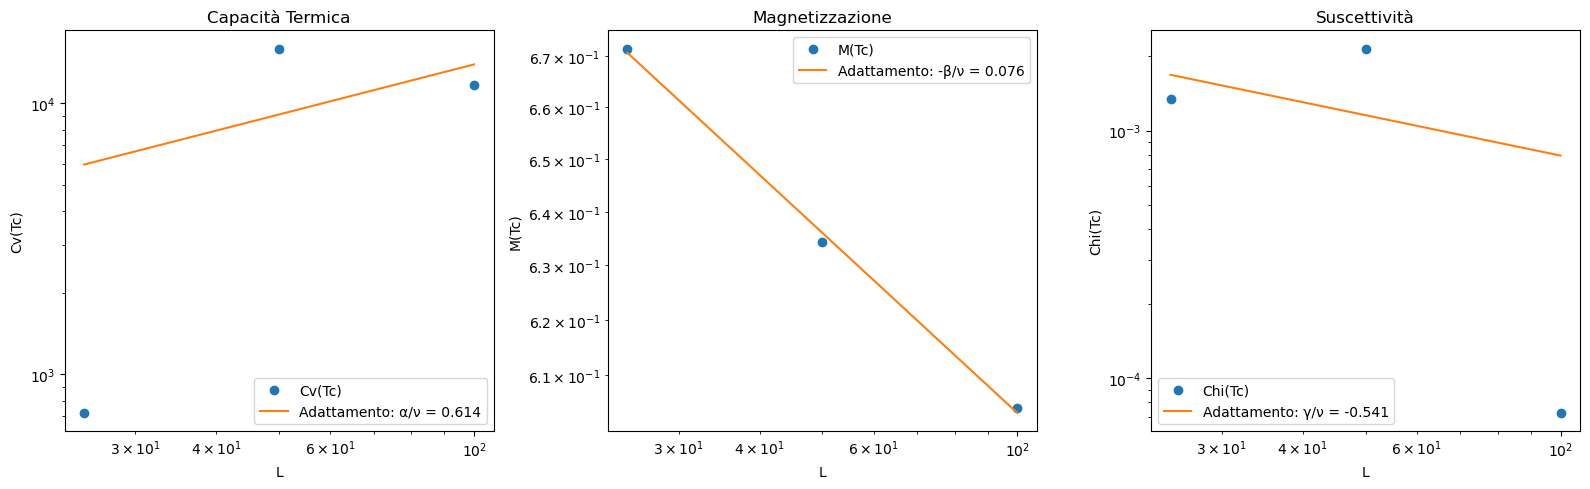

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Power law function
def power_law(x, a, b):
    return a * x**b

# Dati dal dataframe, utilizzando L = sqrt(N) come dimensione del sistema
L_values = (df['N'].unique())

# Estrazione di Cv(Tc), M(Tc), e Chi(Tc) dal DataFrame
Cv_at_Tc = np.array([df[(df['N'] == N) & (df['T'] == 2.5)]['specific_heat'].values[0] for N in df['N'].unique()])
M_at_Tc = np.array([df[(df['N'] == N) & (df['T'] == 2.5)]['average_magnetization'].values[0] for N in df['N'].unique()])
Chi_at_Tc = np.array([df[(df['N'] == N) & (df['T'] == 2.5)]['susceptibility'].values[0] for N in df['N'].unique()])

# Adattamento e analisi della capacità termica (Cv ~ L^α/ν)
params_Cv, _ = curve_fit(power_law, L_values, Cv_at_Tc)
alpha_over_nu = params_Cv[1]

# Adattamento e analisi della magnetizzazione (M ~ L^(-β/ν))
params_M, _ = curve_fit(power_law, L_values, M_at_Tc)
beta_over_nu = -params_M[1]

# Adattamento e analisi della suscettività (Chi ~ L^γ/ν)
params_Chi, _ = curve_fit(power_law, L_values, Chi_at_Tc)
gamma_over_nu = params_Chi[1]

# Stampa dei risultati
print(f'Estimativa di α/ν: {alpha_over_nu}')
print(f'Estimativa di β/ν: {beta_over_nu}')
print(f'Estimativa di γ/ν: {gamma_over_nu}')

# Plot dei risultati della legge di potenza
plt.figure(figsize=(16, 5))

# Specific Heat (Cv)
plt.subplot(1, 3, 1)
plt.plot(L_values, Cv_at_Tc, 'o', label='Cv(Tc)')
plt.plot(L_values, power_law(L_values, *params_Cv), '-', label=f'Adattamento: α/ν = {alpha_over_nu:.3f}')
plt.xlabel('L')
plt.ylabel('Cv(Tc)')
plt.xscale('log')
plt.yscale('log')
plt.title('Capacità Termica')
plt.legend()

# Magnetization (M)
plt.subplot(1, 3, 2)
plt.plot(L_values, M_at_Tc, 'o', label='M(Tc)')
plt.plot(L_values, power_law(L_values, *params_M), '-', label=f'Adattamento: -β/ν = {beta_over_nu:.3f}')
plt.xlabel('L')
plt.ylabel('M(Tc)')
plt.xscale('log')
plt.yscale('log')
plt.title('Magnetizzazione')
plt.legend()

# Susceptibility (Chi)
plt.subplot(1, 3, 3)
plt.plot(L_values, Chi_at_Tc, 'o', label='Chi(Tc)')
plt.plot(L_values, power_law(L_values, *params_Chi), '-', label=f'Adattamento: γ/ν = {gamma_over_nu:.3f}')
plt.xlabel('L')
plt.ylabel('Chi(Tc)')
plt.xscale('log')
plt.yscale('log')
plt.title('Suscettività')
plt.legend()

plt.tight_layout()
plt.show()
